In [48]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import font_manager
from scipy import stats
from copy import copy
import pandas as pd
import datetime

In [2]:
%matplotlib inline

label_font = font_manager.FontProperties(
    family=['Fira Sans'],
    weight='regular',
    size=20
)
tick_font = font_manager.FontProperties(
    family=['Fira Sans'],
    weight='regular',
    size=14
)
pub_font = font_manager.FontProperties(
#     family=['cmr10'],
    weight='regular',
    size=32
)
publish = False
if publish:
    matplotlib.rcParams.update(
        {
            'text.usetex': True,
            'font.family': 'cmr10',
            'mathtext.fontset': 'cm',
        }
    )

In [3]:
def seir(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+R+G+H),
        b*S*I/(S+E+I+R+G+H)-g*E,
        g*E-(e+a+m)*I,
        e*I-d*H,
        d*H,
        e*I,
        m*I,
        g*E,
        e*I
    ]

In [4]:
read_file = True
if read_file:
    raw_data = pd.read_csv("../samoa-data/samoa_press_release_data.csv", 
                           header=0, dayfirst=True, parse_dates=True, skiprows=[1])

In [5]:
the_dates = list(map(lambda t: datetime.datetime.strptime(t, "%d/%m/%Y"), raw_data.Date.values))
def time_conv(time: float):
    return the_dates[0] + datetime.timedelta(days=time)

In [6]:
date_tick = [datetime.date(2019, M, 1) for M in [10, 11, 12]] + [datetime.date(2020, 1, 1)]
date_tick_label = ['Oct\n2019', 'Nov', 'Dec', 'Jan\n2020']

ex_date_tick = date_tick + [datetime.date(2020,2,1)]
ex_date_label = date_tick_label + ['Feb']

In [7]:
time, cE, H, cH, D, G = raw_data.iloc[:,1:].values.T

In [8]:
data_pd = np.vstack([H, G, D, cE, cH]).astype(float).T
start = 0
clip = 17
data_time = time[start:clip]
data_pd = data_pd[start:clip,:]

p0 = [2, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6]
config = {
    "grid_size": 200,
    "basis_number": 40,
    "model_form": {
        "state": 9,
        "parameters": 6
    },
    "time_span": [time[0], time[-1]*1.25],
#     "time_span": [time[0], 150],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(data_time)},
    "observation_vector": [3,4,6,7,8],
    "weightings":[
        [1]*9,
        np.sqrt((data_time+1)/np.mean(data_time+1))
    ],
    "regularisation_value": copy(p0),
}

In [9]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 50,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [10]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
fr_ex = ca.Function('fr_ex', [solver_setup['x']], [objective.regularisation])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)

In [11]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(9)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*9) + [0]*len(config['regularisation_value'])
alpha = 3e1

In [12]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0


  50 3.8323236e+001 0.00e+000 1.05e-001  -3.8 3.59e+003    -  1.00e+000 1.00e+000f  1
 100 3.8333707e+001 0.00e+000 5.15e-001  -3.8 3.50e+001  -8.2 1.00e+000 1.00e+000f  1
 150 3.8268993e+001 0.00e+000 7.33e-001  -5.7 6.06e+003    -  8.48e-001 5.00e-001f  2
 200 3.8256390e+001 0.00e+000 4.86e-002  -5.7 1.53e+001    -  1.00e+000 1.00e+000f  1
 250 3.8254948e+001 0.00e+000 3.25e-003  -5.7 4.06e+000    -  1.00e+000 1.00e+000h  1
 300 3.8254576e+001 0.00e+000 7.87e-002  -5.7 1.35e+001    -  1.00e+000 1.00e+000h  1
 350 3.8253969e+001 0.00e+000 1.36e-003  -8.6 3.72e+000    -  1.00e+000 1.00e+000h  1
 400 3.8253863e+001 0.00e+000 6.65e-002  -8.6 3.77e+001    -  1.00e+000 1.00e+000h  1
 450 3.8253806e+001 0.00e+000 1.91e-003  -8.6 1.07e+001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 3.8253776e+001 0.00e+000 1.50e-002  -8.6 4.28e+001    -  1.00e+000 1.00e+000h  1
 550 3.8253757e+001 0.00e+000 3.44e-004  -8.6 1.04e+001    

1400 3.8341351e+001 0.00e+000 2.63e-004  -8.6 1.60e+002    -  1.00e+000 1.00e+000h  1
1450 3.8341351e+001 0.00e+000 8.40e-003  -8.6 1.53e+004    -  1.00e+000 3.12e-002h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 3.8341350e+001 0.00e+000 1.93e-003  -8.6 9.89e+002    -  1.00e+000 5.00e-001h  2
1550 3.8341350e+001 0.00e+000 8.11e-003  -8.6 2.27e+003    -  1.00e+000 5.00e-001h  2
1600 3.8341350e+001 0.00e+000 7.37e-004  -8.6 3.64e+002    -  1.00e+000 1.00e+000h  1
1650 3.8341350e+001 0.00e+000 8.58e-004  -8.6 4.11e+002    -  1.00e+000 1.00e+000h  1
1700 3.8341350e+001 0.00e+000 2.10e-003  -8.6 6.69e+002    -  1.00e+000 1.00e+000h  1
1750 3.8341350e+001 0.00e+000 1.88e-005  -8.6 7.28e+001    -  1.00e+000 1.00e+000h  1
1800 3.8341350e+001 0.00e+000 2.58e-003  -8.6 5.20e+003    -  1.00e+000 1.25e-001h  4
1850 3.8341349e+001 0.00e+000 5.70e-005  -8.6 1.28e+002    -  1.00e+000 1.00e+000h  1
1900 3.8341349e+001 0.00e+000 1.16e-003  -8.6 5.82e+002    

1750 3.8445453e+001 0.00e+000 5.12e-004  -8.6 2.70e+002    -  1.00e+000 1.00e+000h  1
1800 3.8445452e+001 0.00e+000 1.21e-003  -8.6 4.30e+002    -  1.00e+000 1.00e+000h  1
1850 3.8445452e+001 0.00e+000 2.28e-003  -8.6 2.13e+003    -  1.00e+000 2.50e-001h  3
1900 3.8445452e+001 0.00e+000 8.59e-004  -8.6 3.93e+002    -  1.00e+000 1.00e+000h  1
1950 3.8445452e+001 0.00e+000 4.35e-003  -8.6 3.47e+003    -  1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 3.8445452e+001 0.00e+000 3.39e-003  -8.6 3.16e+003    -  1.00e+000 2.50e-001h  3
2050 3.8445452e+001 0.00e+000 6.47e-005  -8.6 1.24e+002    -  1.00e+000 1.00e+000h  1
2100 3.8445452e+001 0.00e+000 9.06e-003  -8.6 7.24e+003    -  1.00e+000 1.25e-001h  4
2150 3.8445452e+001 0.00e+000 3.85e-004  -8.6 3.12e+002    -  1.00e+000 1.00e+000h  1
2200 3.8445452e+001 0.00e+000 2.18e-005  -8.6 8.25e+001    -  1.00e+000 1.00e+000h  1
2250 3.8445452e+001 0.00e+000 6.26e-004  -8.6 4.22e+002    

1700 3.8567581e+001 0.00e+000 4.23e-003  -8.6 6.45e+002    -  1.00e+000 1.00e+000h  1
1750 3.8567581e+001 0.00e+000 7.92e-004  -8.6 2.94e+002    -  1.00e+000 1.00e+000h  1
1800 3.8567581e+001 0.00e+000 7.92e-003  -8.6 9.63e+002    -  1.00e+000 1.00e+000h  1
1850 3.8567581e+001 0.00e+000 2.56e-004  -8.6 1.83e+002    -  1.00e+000 1.00e+000h  1
1900 3.8567581e+001 0.00e+000 4.36e-002  -8.6 1.86e+004    -  1.00e+000 3.12e-002h  6
1950 3.8567581e+001 0.00e+000 5.94e-005  -8.6 9.83e+001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 3.8567580e+001 0.00e+000 1.01e-002  -8.6 2.51e+003    -  1.00e+000 5.00e-001h  2
2050 3.8567580e+001 0.00e+000 5.59e-006  -8.6 4.50e+001    -  1.00e+000 1.00e+000h  1
2100 3.8567580e+001 0.00e+000 8.50e-004  -8.6 3.96e+002    -  1.00e+000 1.00e+000h  1
2150 3.8567580e+001 0.00e+000 3.47e-003  -8.6 8.21e+002    -  1.00e+000 1.00e+000h  1
2200 3.8567580e+001 0.00e+000 1.07e-001  -8.6 4.50e+004    

1600 3.8708381e+001 0.00e+000 3.28e-003  -8.6 3.36e+002    -  1.00e+000 1.00e+000h  1
1650 3.8708381e+001 0.00e+000 8.80e-004  -8.6 1.94e+002    -  1.00e+000 1.00e+000h  1
1700 3.8708381e+001 0.00e+000 6.16e-006  -8.6 2.10e+001    -  1.00e+000 1.00e+000h  1
1750 3.8708380e+001 0.00e+000 9.97e-003  -8.6 2.44e+003    -  1.00e+000 1.25e-001h  4
1800 3.8708380e+001 0.00e+000 5.98e-003  -8.6 6.03e+002    -  1.00e+000 1.00e+000h  1
1850 3.8708380e+001 0.00e+000 4.87e-003  -8.6 1.08e+003    -  1.00e+000 5.00e-001h  2
1900 3.8708379e+001 0.00e+000 5.60e-005  -8.6 6.82e+001    -  1.00e+000 1.00e+000h  1
1950 3.8708379e+001 0.00e+000 2.91e-002  -8.6 6.65e+003    -  1.00e+000 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 3.8708379e+001 0.00e+000 5.10e-003  -8.6 1.26e+003    -  1.00e+000 5.00e-001h  2
2050 3.8708379e+001 0.00e+000 7.16e-002  -8.6 1.59e+004    -  1.00e+000 3.12e-002h  6
2100 3.8708379e+001 0.00e+000 9.55e-005  -8.6 1.02e+002    

1500 3.8867696e+001 0.00e+000 3.13e-003  -8.6 1.47e+002    -  1.00e+000 1.00e+000h  1
1550 3.8867695e+001 0.00e+000 3.37e-003  -8.6 1.73e+002    -  1.00e+000 1.00e+000h  1
1600 3.8867694e+001 0.00e+000 1.45e-002  -8.6 7.88e+002    -  1.00e+000 5.00e-001h  2
1650 3.8867693e+001 0.00e+000 1.29e-003  -8.6 1.33e+002    -  1.00e+000 1.00e+000h  1
1700 3.8867693e+001 0.00e+000 5.61e-004  -8.6 9.86e+001    -  1.00e+000 1.00e+000h  1
1750 3.8867692e+001 0.00e+000 2.47e-003  -8.6 2.29e+002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 1785

                                   (scaled)                 (unscaled)
Objective...............:  3.8867691458159065e+001   3.8867691458159065e+001
Dual infeasibility......:  3.9636953256584995e-009   3.9636953256584995e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059036572383148e-009   2.5059036572383148e-009
Overall NLP error.......:  3.9636953256584995e-009   3.9636953256584995e

  50 4.0683340e+001 0.00e+000 3.91e+001  -2.5 9.73e+003    -  1.00e+000 8.29e-001f  1
 100 4.1066597e+001 0.00e+000 1.56e+001  -2.5 1.90e+004    -  1.00e+000 1.00e+000f  1
 150 4.0234929e+001 0.00e+000 6.88e+000  -5.7 3.47e+003 -11.2 1.00e+000 1.00e+000f  1
 200 3.9438227e+001 0.00e+000 3.95e+000  -5.7 4.14e+003 -11.8 1.00e+000 7.88e-001f  1
 250 3.9260622e+001 0.00e+000 2.13e+000  -5.7 1.73e+002    -  1.00e+000 2.50e-001f  3
 300 3.9250709e+001 0.00e+000 8.93e-002  -5.7 3.16e+000    -  1.00e+000 1.00e+000f  1
 350 3.9247999e+001 0.00e+000 6.83e-002  -5.7 2.23e+000    -  1.00e+000 1.00e+000h  1
 400 3.9246813e+001 0.00e+000 1.37e-002  -5.7 1.82e+000    -  1.00e+000 1.00e+000h  1
 450 3.9246290e+001 0.00e+000 3.80e-002  -5.7 4.42e+000    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 3.9245967e+001 0.00e+000 2.99e-004  -5.7 9.62e-001    -  1.00e+000 1.00e+000f  1
 550 3.9245815e+001 0.00e+000 5.22e-002  -5.7 1.58e+002    

 800 3.9467316e+001 0.00e+000 1.02e-002  -8.6 1.76e+001    -  1.00e+000 1.00e+000h  1
 850 3.9467295e+001 0.00e+000 5.91e-003  -8.6 1.66e+001    -  1.00e+000 1.00e+000h  1
 900 3.9467279e+001 0.00e+000 3.50e-003  -8.6 1.56e+001    -  1.00e+000 1.00e+000h  1
 950 3.9467266e+001 0.00e+000 3.34e-003  -8.6 1.86e+001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 3.9467256e+001 0.00e+000 5.86e-002  -8.6 3.64e+002    -  1.00e+000 2.50e-001h  3
1050 3.9467249e+001 0.00e+000 4.58e-002  -8.6 9.61e+001    -  1.00e+000 1.00e+000h  1
1100 3.9467243e+001 0.00e+000 4.66e-003  -8.6 3.57e+001    -  1.00e+000 1.00e+000h  1
1150 3.9467238e+001 0.00e+000 3.76e-003  -8.6 3.68e+001    -  1.00e+000 1.00e+000h  1
1200 3.9467234e+001 0.00e+000 1.73e-002  -8.6 8.96e+001    -  1.00e+000 1.00e+000h  1
1250 3.9467231e+001 0.00e+000 3.39e-002  -8.6 2.29e+003    -  1.00e+000 3.12e-002h  6
1300 3.9467228e+001 0.00e+000 1.40e-002  -8.6 1.86e+002    

 700 3.9741713e+001 0.00e+000 1.11e-001  -8.6 6.41e+001    -  1.00e+000 5.00e-001h  2
 750 3.9741681e+001 0.00e+000 6.15e-002  -8.6 3.08e+001    -  1.00e+000 1.00e+000h  1
 800 3.9741658e+001 0.00e+000 2.70e-002  -8.6 2.47e+001    -  1.00e+000 1.00e+000h  1
 850 3.9741638e+001 0.00e+000 1.79e-003  -8.6 7.98e+000    -  1.00e+000 1.00e+000h  1
 900 3.9741623e+001 0.00e+000 5.19e-003  -8.6 1.59e+001    -  1.00e+000 1.00e+000h  1
 950 3.9741617e+001 0.00e+000 2.73e-001  -8.6 1.34e+002    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 3.9741600e+001 0.00e+000 2.94e-003  -8.6 1.71e+001    -  1.00e+000 1.00e+000h  1
1050 3.9741591e+001 0.00e+000 5.28e-002  -8.6 2.45e+003    -  1.00e+000 3.12e-002h  6
1100 3.9743422e+001 0.00e+000 4.98e+000  -8.6 9.76e+002    -  1.00e+000 1.00e+000H  1
1150 3.9741579e+001 0.00e+000 7.40e-003  -8.6 4.43e+001    -  1.00e+000 1.00e+000h  1
1200 3.9741575e+001 0.00e+000 1.72e-002  -8.6 7.70e+001    

 600 4.0094383e+001 0.00e+000 6.25e-003  -5.7 1.46e+000    -  1.00e+000 1.00e+000h  1
 650 4.0094180e+001 0.00e+000 3.93e-002  -5.7 4.57e+000    -  1.00e+000 1.00e+000h  1
 700 4.0094060e+001 0.00e+000 9.44e-002  -5.7 6.76e+001    -  1.00e+000 1.25e-001h  4
 750 4.0093977e+001 0.00e+000 4.40e-004  -5.7 7.84e-001    -  1.00e+000 1.00e+000h  1
 800 4.0093918e+001 0.00e+000 2.89e-002  -5.7 1.26e+001    -  1.00e+000 5.00e-001h  2
 850 4.0093510e+001 0.00e+000 8.95e-002  -8.6 1.51e+001    -  1.00e+000 1.00e+000h  1
 900 4.0093452e+001 0.00e+000 2.05e-002  -8.6 9.11e+000    -  1.00e+000 1.00e+000h  1
 950 4.0093408e+001 0.00e+000 2.26e-002  -8.6 1.18e+001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.0093376e+001 0.00e+000 6.27e-002  -8.6 2.35e+001    -  1.00e+000 1.00e+000h  1
1050 4.0093351e+001 0.00e+000 5.79e-002  -8.6 2.72e+001    -  1.00e+000 1.00e+000h  1
1100 4.0093330e+001 0.00e+000 1.10e-002  -8.6 1.41e+001    

 500 4.0530576e+001 0.00e+000 4.74e-004  -5.7 1.02e+002    -  1.00e+000 1.00e+000f  1
 550 4.0530291e+001 0.00e+000 2.27e-002  -5.7 2.38e+000    -  1.00e+000 1.00e+000h  1
 600 4.0530118e+001 0.00e+000 1.32e-001  -5.7 7.18e+000    -  1.00e+000 1.00e+000h  1
 650 4.0530007e+001 0.00e+000 1.66e-001  -5.7 1.91e+001    -  1.00e+000 5.00e-001h  2
 700 4.0529930e+001 0.00e+000 1.13e-005  -5.7 6.97e+000    -  1.00e+000 1.00e+000h  1
 750 4.0529471e+001 0.00e+000 4.28e-001  -8.6 4.43e+001    -  1.00e+000 5.00e-001h  2
 800 4.0529375e+001 0.00e+000 2.31e-001  -8.6 4.38e+001    -  1.00e+000 5.00e-001h  2
 850 4.0529331e+001 0.00e+000 6.84e-002  -8.6 2.49e+001    -  1.00e+000 5.00e-001h  2
 900 4.0529297e+001 0.00e+000 1.40e-002  -8.6 8.00e+000    -  1.00e+000 1.00e+000h  1
 950 4.0529270e+001 0.00e+000 6.17e-004  -8.6 2.28e+000    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.0529248e+001 0.00e+000 2.48e-002  -8.6 1.47e+001    

 550 4.1039118e+001 0.00e+000 7.30e-001  -5.7 1.33e+001    -  1.00e+000 2.50e-001h  3
 600 4.1038199e+001 0.00e+000 4.99e-001  -5.7 3.22e+001    -  1.00e+000 1.25e-001h  4
 650 4.1037644e+001 0.00e+000 2.20e-002  -5.7 1.24e+000    -  1.00e+000 1.00e+000h  1
 700 4.1037326e+001 0.00e+000 8.62e-003  -5.7 1.04e+000    -  1.00e+000 1.00e+000h  1
 750 4.1037112e+001 0.00e+000 1.12e-001  -5.7 1.46e+002    -  1.00e+000 3.12e-002h  6
 800 4.1036986e+001 0.00e+000 2.36e-001  -5.7 1.57e+001    -  1.00e+000 5.00e-001h  2
 850 4.1036896e+001 0.00e+000 2.53e-002  -5.7 3.13e+000    -  1.00e+000 1.00e+000h  1
 900 4.1036830e+001 0.00e+000 4.91e-003  -5.7 1.60e+000    -  1.00e+000 1.00e+000h  1
 950 4.1036786e+001 0.00e+000 6.40e-002  -5.7 2.51e+001    -  1.00e+000 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.1036762e+001 0.00e+000 1.83e-003  -5.7 2.29e+000    -  1.00e+000 5.00e-001h  2
1050 4.1036287e+001 0.00e+000 1.91e-001  -8.6 1.39e+001    

 500 4.1627031e+001 0.00e+000 1.73e-001  -5.7 2.14e+000    -  1.00e+000 1.00e+000h  1
 550 4.1626598e+001 0.00e+000 8.21e-003  -5.7 6.62e-001    -  1.00e+000 1.00e+000h  1
 600 4.1626343e+001 0.00e+000 2.00e-001  -5.7 1.40e+001    -  1.00e+000 2.50e-001h  3
 650 4.1626159e+001 0.00e+000 8.74e-002  -5.7 3.14e+000    -  1.00e+000 1.00e+000h  1
 700 4.1626028e+001 0.00e+000 4.93e-003  -5.7 9.36e-001    -  1.00e+000 1.00e+000h  1
 750 4.1625940e+001 0.00e+000 1.83e-002  -5.7 2.07e+000    -  1.00e+000 1.00e+000h  1
 800 4.1625884e+001 0.00e+000 1.99e-002  -5.7 2.43e+000    -  1.00e+000 1.00e+000h  1
 850 4.1625845e+001 0.00e+000 3.19e-002  -5.7 6.27e+000    -  1.00e+000 5.00e-001h  2
 900 4.1625824e+001 0.00e+000 1.51e-002  -5.7 9.78e+000    -  1.00e+000 2.50e-001h  3
 950 4.1625575e+001 0.00e+000 3.15e+000  -8.6 4.18e+001    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.1625297e+001 0.00e+000 1.70e-001  -8.6 2.19e+001    

 450 4.2977944e+001 0.00e+000 1.24e+000  -5.7 3.04e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 4.2974962e+001 0.00e+000 8.63e-001  -5.7 4.05e+000    -  1.00e+000 1.00e+000h  1
 550 4.2973294e+001 0.00e+000 4.99e-001  -5.7 1.63e+001    -  1.00e+000 2.50e-001h  3
 600 4.2972277e+001 0.00e+000 2.62e-002  -5.7 1.61e+000    -  1.00e+000 1.00e+000f  1
 650 4.2971639e+001 0.00e+000 5.52e-003  -5.7 1.13e+000    -  1.00e+000 1.00e+000f  1
 700 4.2971230e+001 0.00e+000 2.86e-001  -5.7 1.65e+001    -  1.00e+000 5.00e-001h  2
 750 4.2970964e+001 0.00e+000 5.55e-002  -5.7 5.23e+000    -  1.00e+000 1.00e+000h  1
 800 4.2970774e+001 0.00e+000 9.86e-002  -5.7 8.60e+000    -  1.00e+000 1.00e+000h  1
 850 4.2970625e+001 0.00e+000 2.83e-001  -5.7 3.47e+001    -  1.00e+000 5.00e-001h  2
 900 4.2970519e+001 0.00e+000 3.07e-001  -5.7 4.39e+001    -  1.00e+000 5.00e-001h  2
 950 4.2970449e+001 0.00e+000 1.75e-002  -5.7 6.15e+000    

 450 4.4011751e+001 0.00e+000 9.27e+000  -3.8 7.18e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 4.3918954e+001 0.00e+000 7.38e-001  -3.8 5.10e+001    -  1.00e+000 1.00e+000f  1
 550 4.3895591e+001 0.00e+000 1.23e-001  -3.8 9.31e+000    -  1.00e+000 1.00e+000h  1
 600 4.3831843e+001 0.00e+000 1.10e+001  -5.7 9.73e+002    -  3.11e-001 1.00e+000f  1
 650 4.3822898e+001 0.00e+000 1.15e+000  -5.7 2.61e+000    -  1.00e+000 1.00e+000f  1
 700 4.3818676e+001 0.00e+000 1.17e+000  -5.7 3.22e+000    -  1.00e+000 1.00e+000f  1
 750 4.3816342e+001 0.00e+000 5.84e-001  -5.7 5.27e+001    -  1.00e+000 6.25e-002f  5
 800 4.3814918e+001 0.00e+000 4.45e-001  -5.7 4.35e+000    -  1.00e+000 1.00e+000h  1
 850 4.3814024e+001 0.00e+000 1.62e-001  -5.7 3.67e+000    -  1.00e+000 1.00e+000h  1
 900 4.3813441e+001 0.00e+000 6.01e-001  -5.7 7.39e+001    -  1.00e+000 1.25e-001h  4
 950 4.3813120e+001 0.00e+000 1.97e+000  -5.7 4.37e+001    

 350 4.6048671e+001 0.00e+000 9.22e+000  -3.8 8.12e+003    -  1.00e+000 2.50e-001f  3
 400 4.5968424e+001 0.00e+000 5.73e+000  -3.8 8.74e+003 -12.6 1.00e+000 2.50e-001f  3
 450 4.5272922e+001 0.00e+000 1.86e+001  -3.8 6.40e+003 -11.6 1.00e+000 3.30e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 4.4962481e+001 0.00e+000 1.71e+001  -3.8 1.25e+004 -10.1 1.37e-001 7.80e-003f  4
 550 4.4863456e+001 0.00e+000 5.97e+000  -3.8 3.18e+001    -  1.00e+000 1.00e+000f  1
 600 4.4837825e+001 0.00e+000 3.00e-001  -3.8 3.79e+000    -  1.00e+000 1.00e+000f  1
 650 4.4777286e+001 0.00e+000 4.77e-001  -5.7 1.26e+001    -  1.00e+000 1.00e+000f  1
 700 4.4767517e+001 0.00e+000 2.08e+000  -5.7 1.53e+001    -  1.00e+000 2.50e-001f  3
 750 4.4762640e+001 0.00e+000 2.66e+000  -5.7 3.71e+000    -  1.00e+000 1.00e+000f  1
 800 4.4759847e+001 0.00e+000 2.86e-001  -5.7 1.84e+000    -  1.00e+000 1.00e+000f  1
 850 4.4758198e+001 0.00e+000 1.28e-001  -5.7 1.76e+000    

 350 4.6901938e+001 0.00e+000 6.65e+000  -5.7 1.59e+003 -13.6 1.00e+000 1.00e+000f  1
 400 4.6898838e+001 0.00e+000 9.85e-001  -5.7 3.66e+002 -12.6 1.00e+000 1.00e+000f  1
 450 4.6894237e+001 0.00e+000 4.77e+000  -5.7 2.44e+003 -13.4 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 4.6886863e+001 0.00e+000 3.23e+000  -5.7 1.55e+003 -12.4 1.00e+000 2.50e-001f  3
 550 4.6877338e+001 0.00e+000 2.93e+000  -5.7 1.76e+002 -10.0 1.00e+000 1.00e+000f  1
 600 4.6871570e+001 0.00e+000 4.93e-003  -5.7 1.84e+000  -8.5 1.00e+000 1.00e+000f  1
 650 4.6870316e+001 0.00e+000 3.03e-005  -8.6 2.46e-001  -6.1 1.00e+000 1.00e+000f  1

Number of Iterations....: 695

                                   (scaled)                 (unscaled)
Objective...............:  4.6870197880305589e+001   4.6870197880305589e+001
Dual infeasibility......:  4.9150491620282513e-009   4.9150491620282513e-009
Constraint violation....:  0.0000000000000000e+000   0.00000

  50 5.1810880e+001 0.00e+000 1.74e+001  -2.5 1.81e+004    -  7.03e-001 2.50e-001f  3
 100 5.1104497e+001 0.00e+000 1.30e+000  -3.8 1.67e+004 -13.0 1.00e+000 2.56e-002f  5
 150 5.1072231e+001 0.00e+000 5.67e-001  -5.7 2.66e+002 -11.5 1.00e+000 1.00e+000f  1
 200 5.1056805e+001 0.00e+000 6.21e-001  -5.7 5.01e+002 -11.9 1.00e+000 1.00e+000f  1
 250 5.1029555e+001 0.00e+000 4.91e+000  -5.7 3.53e+002 -11.4 1.00e+000 1.00e+000f  1
 300 5.0992404e+001 0.00e+000 1.50e+000  -5.7 3.82e+002 -11.7 1.00e+000 1.00e+000f  1
 350 5.0965979e+001 0.00e+000 3.68e+001  -5.7 1.74e+005    -  6.70e-003 1.18e-002f  1
 400 5.0954866e+001 0.00e+000 5.75e-002  -8.6 6.78e+001 -12.0 1.00e+000 9.94e-001f  1

Number of Iterations....: 431

                                   (scaled)                 (unscaled)
Objective...............:  5.0954443258263069e+001   5.0954443258263069e+001
Dual infeasibility......:  1.1679889013332752e-010   1.1679889013332752e-010
Constraint violation....:  0.0000000000000000e+000   0.

 100 5.8164848e+001 0.00e+000 9.76e+001  -3.8 1.05e+004  -9.9 1.58e-001 2.14e-001f  3
 150 5.6962738e+001 0.00e+000 6.10e+001  -3.8 1.18e+003 -10.5 1.00e+000 1.00e+000f  1
 200 5.6916058e+001 0.00e+000 7.94e+000  -3.8 5.40e+003    -  1.00e+000 5.00e-001f  2
 250 5.6901436e+001 0.00e+000 3.52e-001  -3.8 2.03e+002    -  1.00e+000 5.00e-001h  2
 300 5.6850050e+001 0.00e+000 2.69e+001  -5.7 8.69e+002 -12.0 1.00e+000 1.00e+000f  1
 350 5.6798811e+001 0.00e+000 1.12e+001  -5.7 8.34e+002 -11.5 1.00e+000 1.00e+000f  1
 400 5.6730115e+001 0.00e+000 3.71e+001  -5.7 6.30e+002 -11.0 1.00e+000 1.00e+000f  1
 450 5.6673132e+001 0.00e+000 5.07e+000  -5.7 4.64e+002 -11.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 5.6653039e+001 0.00e+000 1.74e+001  -5.7 7.24e+003    -  5.11e-001 1.19e-001f  1
 550 5.6651513e+001 0.00e+000 3.89e-002  -8.6 2.15e+003 -14.9 1.00e+000 1.00e+000h  1
 600 5.6651360e+001 0.00e+000 6.71e-003  -8.6 1.94e+002 -12

 450 6.2746329e+001 0.00e+000 3.87e+001  -3.8 1.61e+003 -12.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 6.2683856e+001 0.00e+000 2.83e+001  -3.8 3.40e+002 -11.9 1.00e+000 1.00e+000f  1
 550 6.2628644e+001 0.00e+000 8.00e+000  -5.7 2.32e+002 -10.5 1.00e+000 1.00e+000f  1
 600 6.2619259e+001 0.00e+000 5.77e+000  -5.7 3.76e+002 -11.6 1.00e+000 1.00e+000f  1

Number of Iterations....: 644

                                   (scaled)                 (unscaled)
Objective...............:  6.2618194857722564e+001   6.2618194857722564e+001
Dual infeasibility......:  6.8493951594147911e-011   6.8493951594147911e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5066410241613520e-009   2.5066410241613520e-009
Overall NLP error.......:  2.5066410241613520e-009   2.5066410241613520e-009


Number of objective function evaluations             = 1295
Number of objective gradi

  50 1.1179443e+002 0.00e+000 3.46e+002  -1.0 3.00e+003    -  1.00e+000 5.00e-001f  2
 100 8.4841933e+001 0.00e+000 7.64e+001  -2.5 2.02e+003 -11.3 1.00e+000 1.00e+000f  1
 150 8.1529558e+001 0.00e+000 2.22e+002  -2.5 3.00e+003  -9.1 1.00e+000 5.00e-001f  2
 200 7.7001803e+001 0.00e+000 2.51e+001  -2.5 1.57e+003    -  1.00e+000 5.00e-001f  2
 250 7.6204986e+001 0.00e+000 3.28e+001  -3.8 4.67e+004    -  1.00e+000 6.25e-002f  5
 300 7.6182023e+001 0.00e+000 2.68e+001  -3.8 1.85e+003 -10.9 1.00e+000 5.00e-001f  2
 350 7.6154887e+001 0.00e+000 2.33e+001  -3.8 1.14e+004 -12.0 3.55e-001 6.25e-002f  5
 400 7.6113015e+001 0.00e+000 6.79e+001  -3.8 1.71e+003 -11.7 1.00e+000 5.00e-001f  2
 450 7.6051250e+001 0.00e+000 5.94e+001  -3.8 4.39e+002 -12.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 7.5980236e+001 0.00e+000 1.12e+001  -3.8 1.63e+002 -11.4 1.00e+000 1.00e+000f  1
 550 7.5934962e+001 0.00e+000 1.93e+000  -3.8 2.20e+002 -11

 450 8.6558351e+001 0.00e+000 5.65e+001  -3.8 4.08e+002 -11.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 8.6468670e+001 0.00e+000 3.67e+001  -3.8 2.70e+002 -11.0 1.00e+000 1.00e+000f  1
 550 8.6392410e+001 0.00e+000 6.67e+001  -3.8 1.13e+003 -11.4 1.00e+000 2.50e-001f  3
 600 8.6342658e+001 0.00e+000 5.56e+000  -3.8 9.57e+001 -11.2 1.00e+000 1.00e+000f  1
 650 8.6294377e+001 0.00e+000 5.33e+000  -5.7 5.31e+002 -11.3 1.00e+000 1.00e+000f  1
 700 8.6290540e+001 0.00e+000 4.24e-008  -8.6 5.19e-001    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 701

                                   (scaled)                 (unscaled)
Objective...............:  8.6290539707256656e+001   8.6290539707256656e+001
Dual infeasibility......:  2.6581403744785348e-011   2.6581403744785348e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596800568e-009   2.50590355968005

  50 1.2909487e+002 0.00e+000 2.09e+003  -1.0 1.30e+003  -8.9 1.00e+000 1.00e+000f  1
 100 1.0821750e+002 0.00e+000 6.05e+000  -1.7 8.37e+001  -9.5 1.00e+000 1.00e+000f  1
 150 1.0456279e+002 0.00e+000 6.58e+001  -3.8 3.31e+002 -10.1 1.00e+000 1.00e+000f  1
 200 1.0454598e+002 0.00e+000 3.29e+000  -3.8 5.21e+001  -9.9 1.00e+000 1.00e+000f  1
 250 1.0453059e+002 0.00e+000 5.43e-001  -3.8 8.14e+001 -10.2 1.00e+000 1.00e+000f  1
 300 1.0451078e+002 0.00e+000 8.08e+001  -3.8 1.55e+005    -  2.92e-001 9.60e-003f  5
 350 1.0447620e+002 0.00e+000 6.47e+001  -3.8 4.95e+002 -10.9 1.00e+000 1.00e+000f  1
 400 1.0440672e+002 0.00e+000 6.99e+001  -3.8 3.45e+002 -10.4 1.00e+000 1.00e+000f  1
 450 1.0426105e+002 0.00e+000 1.00e+002  -3.8 6.50e+002 -10.7 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.0402139e+002 0.00e+000 1.44e+001  -3.8 1.28e+002 -10.2 1.00e+000 1.00e+000f  1
 550 1.0384323e+002 0.00e+000 2.68e+001  -3.8 4.30e+004    

 350 1.1783646e+002 0.00e+000 1.25e+000  -3.8 1.47e+002 -10.1 1.00e+000 1.00e+000f  1
 400 1.1780427e+002 0.00e+000 2.61e+000  -3.8 4.55e+002 -10.5 1.00e+000 1.00e+000f  1
 450 1.1775325e+002 0.00e+000 6.68e-001  -3.8 3.09e+001  -9.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.1769196e+002 0.00e+000 3.13e+000  -3.8 1.02e+002  -9.5 1.00e+000 1.00e+000f  1
 550 1.1757452e+002 0.00e+000 1.39e+001  -3.8 2.03e+003  -9.8 1.00e+000 3.12e-002f  6
 600 1.1738630e+002 0.00e+000 6.20e+001  -3.8 3.41e+002  -9.3 1.00e+000 1.00e+000f  1
 650 1.1686412e+002 0.00e+000 1.49e+001  -3.8 2.03e+002  -8.8 1.00e+000 1.00e+000f  1
 700 1.1624353e+002 0.00e+000 6.18e-002  -3.8 1.23e+001  -8.2 1.00e+000 1.00e+000f  1
 750 1.1623421e+002 0.00e+000 6.07e+001  -3.8 1.24e+003    -  1.00e+000 1.00e+000f  1
 800 1.1621851e+002 0.00e+000 2.91e+000  -5.7 1.26e+001  -9.4 1.00e+000 1.00e+000f  1

Number of Iterations....: 829

                           

 400 1.3352543e+002 0.00e+000 1.89e-001  -3.8 1.03e+002  -9.4 1.00e+000 1.00e+000f  1
 450 1.3337148e+002 0.00e+000 2.04e-001  -3.8 3.32e+000  -7.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.3310941e+002 0.00e+000 7.76e-002  -3.8 3.65e+001  -8.3 1.00e+000 1.00e+000f  1
 550 1.3261001e+002 0.00e+000 3.57e+000  -3.8 2.12e+002  -8.7 1.00e+000 1.00e+000f  1
 600 1.3095901e+002 0.00e+000 8.79e-001  -3.8 1.13e+001  -6.4 1.00e+000 1.00e+000f  1
 650 1.3053564e+002 0.00e+000 1.85e-001  -8.6 1.11e+001 -11.2 1.00e+000 9.97e-001h  1

Number of Iterations....: 655

                                   (scaled)                 (unscaled)
Objective...............:  1.3053558312458378e+002   1.3053558312458378e+002
Dual infeasibility......:  2.4484035651656967e-010   2.4484035651656967e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  3.1730604757226965e-009   3.17306047572269

 550 1.5222942e+002 0.00e+000 3.95e-001  -3.8 3.17e+001  -7.8 1.00e+000 1.00e+000f  1
 600 1.4946103e+002 0.00e+000 6.96e+001  -3.8 3.27e+002  -8.2 1.00e+000 1.00e+000f  1
 650 1.4837593e+002 0.00e+000 1.59e-007  -8.6 5.85e+000    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 651

                                   (scaled)                 (unscaled)
Objective...............:  1.4837592986560739e+002   1.4837592986560739e+002
Dual infeasibility......:  4.7659564642981491e-010   4.7659564642981491e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5122630481077647e-009   2.5122630481077647e-009
Overall NLP error.......:  2.5122630481077647e-009   2.5122630481077647e-009


Number of objective function evaluations             = 1262
Number of objective gradient evaluations             = 652
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1262
Number of equali

  50 2.3212418e+002 0.00e+000 4.96e+003  -1.0 3.46e+003    -  6.16e-001 1.00e+000f  1
 100 2.2561080e+002 0.00e+000 2.25e+003  -1.0 6.34e+003  -8.4 7.28e-001 1.23e-001f  3
 150 2.2514869e+002 0.00e+000 2.00e+002  -1.0 2.58e+002    -  1.00e+000 5.00e-001f  2
 200 2.1321284e+002 0.00e+000 5.34e+001  -1.7 5.46e+001    -  1.00e+000 1.00e+000f  1
 250 2.1002338e+002 0.00e+000 1.07e+003  -3.8 4.49e+002  -8.5 1.00e+000 5.00e-001f  2
 300 2.0777593e+002 0.00e+000 1.44e+003  -3.8 4.77e+002  -8.0 1.00e+000 5.00e-001f  2
 350 2.0439997e+002 0.00e+000 2.04e+001  -3.8 2.11e+001  -6.6 1.00e+000 1.00e+000f  1
 400 2.0032382e+002 0.00e+000 2.08e+002  -3.8 7.12e+001  -7.0 1.00e+000 1.00e+000f  1
 450 1.9837441e+002 0.00e+000 6.77e+000  -3.8 9.37e+001  -7.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.9608132e+002 0.00e+000 3.91e+002  -3.8 7.32e+002  -8.6 1.00e+000 1.00e+000f  1
 550 1.9540002e+002 0.00e+000 2.84e-001  -3.8 1.88e+001  -8

 250 2.6605479e+002 0.00e+000 1.74e+002  -2.5 9.33e+001  -7.8 1.00e+000 1.00e+000f  1
 300 2.6250916e+002 0.00e+000 4.59e+002  -2.5 1.75e+002  -7.7 1.00e+000 1.00e+000f  1
 350 2.5737513e+002 0.00e+000 6.47e+002  -2.5 2.40e+002  -7.6 1.00e+000 1.00e+000f  1
 400 2.5125099e+002 0.00e+000 7.53e+002  -2.5 2.01e+002  -7.1 1.00e+000 5.00e-001f  2
 450 2.4738092e+002 0.00e+000 2.60e+001  -2.5 4.87e+001  -6.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 2.4178118e+002 0.00e+000 6.78e-001  -2.5 1.05e+001  -6.0 1.00e+000 1.00e+000f  1
 550 2.3773879e+002 0.00e+000 1.14e+000  -2.5 1.52e+001  -6.4 1.00e+000 1.00e+000f  1
 600 2.3419339e+002 0.00e+000 4.91e-001  -2.5 2.86e+001  -7.0 1.00e+000 1.00e+000f  1
 650 2.3077517e+002 0.00e+000 1.57e-001  -3.8 1.83e+000  -4.7 1.00e+000 1.00e+000f  1
 700 2.2381716e+002 0.00e+000 2.29e-001  -3.8 1.24e+000  -4.1 1.00e+000 1.00e+000f  1
 750 2.2131259e+002 0.00e+000 4.52e-008  -8.6 2.57e+000    


Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............:  2.9876537039004228e+002   2.9876537039004228e+002
Dual infeasibility......:  1.8501586081004425e-009   1.8501586081004425e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.4455544800389814e-009   1.4455544800389814e-009
Overall NLP error.......:  1.8501586081004425e-009   1.8501586081004425e-009


Number of objective function evaluations             = 43
Number of objective gradient evaluations             = 30
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 43
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 30
Number of Lagrangian Hessian evaluations             = 29
Total CPU secs in IPOPT (w/o function evaluations)   =      0.263
Total CPU secs in NLP function evaluation

  50 5.5516973e+002 0.00e+000 6.18e+000  -5.7 1.48e+003    -  1.00e+000 7.10e-001f  1

Number of Iterations....: 60

                                   (scaled)                 (unscaled)
Objective...............:  5.5516820638477134e+002   5.5516820638477134e+002
Dual infeasibility......:  4.1605967258792343e-009   4.1605967258792343e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1366538624583469e-009   1.1366538624583469e-009
Overall NLP error.......:  4.1605967258792343e-009   4.1605967258792343e-009


Number of objective function evaluations             = 101
Number of objective gradient evaluations             = 61
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 101
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 61
Number of Lagrangian Hessian evaluations             = 60
Total CPU secs in I

  50 9.5103656e+002 0.00e+000 3.61e+000  -3.8 2.64e+003    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 64

                                   (scaled)                 (unscaled)
Objective...............:  9.5100932217538877e+002   9.5100932217538877e+002
Dual infeasibility......:  1.2837107327218015e-010   1.2837107327218015e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.9675282139211441e-010   9.9675282139211441e-010
Overall NLP error.......:  9.9675282139211441e-010   9.9675282139211441e-010


Number of objective function evaluations             = 122
Number of objective gradient evaluations             = 65
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 122
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 65
Number of Lagrangian Hessian evaluations             = 64
Total CPU secs in I

  50 1.5153146e+003 0.00e+000 5.26e-004  -8.6 7.49e+000    -  9.91e-001 7.33e-001f  1

Number of Iterations....: 53

                                   (scaled)                 (unscaled)
Objective...............:  1.5153145711286013e+003   1.5153145711286013e+003
Dual infeasibility......:  3.6210616908011292e-010   3.6210616908011292e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.9168186692297817e-010   9.9168186692297817e-010
Overall NLP error.......:  9.9168186692297817e-010   9.9168186692297817e-010


Number of objective function evaluations             = 89
Number of objective gradient evaluations             = 54
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 89
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 54
Number of Lagrangian Hessian evaluations             = 53
Total CPU secs in IPO


Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:  1.9918392545485485e+003   1.9918392545485485e+003
Dual infeasibility......:  3.5949071182841287e-010   3.5949071182841287e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.8639881916524185e-009   1.8639881916524185e-009
Overall NLP error.......:  1.8639881916524185e-009   1.8639881916524185e-009


Number of objective function evaluations             = 54
Number of objective gradient evaluations             = 43
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 54
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 43
Number of Lagrangian Hessian evaluations             = 42
Total CPU secs in IPOPT (w/o function evaluations)   =      0.407
Total CPU secs in NLP function evaluation

  50 2.6058419e+003 0.00e+000 1.50e+000  -3.8 2.13e+001  -7.4 1.00e+000 1.00e+000f  1

Number of Iterations....: 75

                                   (scaled)                 (unscaled)
Objective...............:  2.6053699972178952e+003   2.6053699972178952e+003
Dual infeasibility......:  2.5735220573883539e-010   2.5735220573883539e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  3.1786067212751952e-009   3.1786067212751952e-009
Overall NLP error.......:  3.1786067212751952e-009   3.1786067212751952e-009


Number of objective function evaluations             = 100
Number of objective gradient evaluations             = 76
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 100
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 76
Number of Lagrangian Hessian evaluations             = 75
Total CPU secs in I

 150 3.0448769e+003 0.00e+000 9.24e+000  -5.7 5.21e+001  -7.5 1.00e+000 1.00e+000f  1
 200 3.0433007e+003 0.00e+000 8.72e+001  -5.7 3.14e-001  -3.7 1.00e+000 1.00e+000f  1

Number of Iterations....: 210

                                   (scaled)                 (unscaled)
Objective...............:  3.0431537221739613e+003   3.0431537221739613e+003
Dual infeasibility......:  7.1862687427168222e-010   7.1862687427168222e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  6.1737017273587568e-009   6.1737017273587568e-009
Overall NLP error.......:  6.1737017273587568e-009   6.1737017273587568e-009


Number of objective function evaluations             = 336
Number of objective gradient evaluations             = 211
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 336
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 3.6956010e+003 0.00e+000 2.57e+001  -3.8 5.38e+001  -7.2 1.00e+000 1.00e+000f  1

Number of Iterations....: 87

                                   (scaled)                 (unscaled)
Objective...............:  3.6947473077036220e+003   3.6947473077036220e+003
Dual infeasibility......:  2.2235487238907846e-009   2.2235487238907846e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059174433859742e-009   2.5059174433859742e-009
Overall NLP error.......:  2.5059174433859742e-009   2.5059174433859742e-009


Number of objective function evaluations             = 98
Number of objective gradient evaluations             = 88
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 98
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 88
Number of Lagrangian Hessian evaluations             = 87
Total CPU secs in IPO


Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:  4.5327808662077741e+003   4.5327808662077741e+003
Dual infeasibility......:  2.6055151779078335e-009   2.6055151779078335e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5085318179971228e-009   2.5085318179971228e-009
Overall NLP error.......:  2.6055151779078335e-009   2.6055151779078335e-009


Number of objective function evaluations             = 39
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 39
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 36
Number of Lagrangian Hessian evaluations             = 35
Total CPU secs in IPOPT (w/o function evaluations)   =      0.362
Total CPU secs in NLP function evaluation

 100 5.4960763e+003 0.00e+000 1.76e+001  -3.8 1.48e+000  -5.0 1.00e+000 1.00e+000f  1
 150 5.4957594e+003 0.00e+000 6.39e-001  -5.7 4.27e+000  -6.4 1.00e+000 1.00e+000f  1
 200 5.4953926e+003 0.00e+000 1.02e-001  -5.7 1.45e-003  -1.1 1.00e+000 1.00e+000f  1
 250 5.4951437e+003 0.00e+000 5.93e+001  -5.7 3.06e+001  -7.3 1.00e+000 1.00e+000f  1
 300 5.4946798e+003 0.00e+000 6.37e-003  -5.7 5.78e-004  -1.5 1.00e+000 1.00e+000h  1

Number of Iterations....: 335

                                   (scaled)                 (unscaled)
Objective...............:  5.4944395662358002e+003   5.4944395662358002e+003
Dual infeasibility......:  7.8526991080040901e-009   7.8526991080040901e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596828287e-009   2.5059035596828287e-009
Overall NLP error.......:  7.8526991080040901e-009   7.8526991080040901e-009


Number of objective function evaluations             = 527
Number of objective g

  50 6.0252424e+003 0.00e+000 3.31e+003  -1.7 1.00e+003    -  7.04e-001 1.56e-002f  7
 100 6.0201148e+003 0.00e+000 4.55e+003  -1.7 6.00e+002    -  7.24e-001 3.12e-002f  6
 150 6.0173505e+003 0.00e+000 1.73e+003  -1.7 4.91e+000  -4.3 1.00e+000 2.50e-001f  3
 200 6.0154521e+003 0.00e+000 7.76e+000  -1.7 2.81e-001  -3.7 1.00e+000 1.00e+000f  1
 250 6.0148754e+003 0.00e+000 2.29e-001  -1.7 1.12e-003  -1.3 1.00e+000 1.00e+000f  1
 300 6.0144123e+003 0.00e+000 4.48e+002  -3.8 1.22e+004    -  1.00e+000 3.70e-003f  7
 350 6.0143647e+003 0.00e+000 5.53e+001  -3.8 1.61e+000  -5.4 1.00e+000 1.00e+000f  1
 400 6.0143105e+003 0.00e+000 1.09e-001  -5.7 1.19e-002  -3.6 1.00e+000 1.00e+000h  1
 450 6.0142945e+003 0.00e+000 2.40e-004  -5.7 2.89e-004  -2.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 6.0142857e+003 0.00e+000 3.52e-001  -8.6 1.19e+000  -6.8 1.00e+000 1.00e+000f  1
 550 6.0142720e+003 0.00e+000 1.88e-002  -8.6 4.59e-004  -2

  50 6.1697031e+003 0.00e+000 1.13e+004  -1.0 1.32e+000  -3.4 1.00e+000 2.50e-001f  3
 100 6.1657465e+003 0.00e+000 4.14e+003  -1.0 1.29e+001  -4.5 1.00e+000 1.25e-001f  4
 150 6.1637684e+003 0.00e+000 1.65e+004  -1.0 2.37e+001  -4.7 1.00e+000 2.50e-001f  3
 200 6.1619233e+003 0.00e+000 1.72e+003  -1.0 2.49e-001  -3.1 1.00e+000 1.00e+000f  1
 250 6.1578218e+003 0.00e+000 1.32e+004  -1.7 1.35e+004    -  7.67e-001 1.56e-002f  7
 300 6.1561915e+003 0.00e+000 9.38e+003  -2.5 6.24e+003    -  1.00e+000 7.81e-003f  8
 350 6.1553446e+003 0.00e+000 4.28e+000  -2.5 2.66e-002  -2.8 1.00e+000 1.00e+000f  1
 400 6.1546574e+003 0.00e+000 1.47e+004  -2.5 5.07e+003    -  1.00e+000 1.56e-002f  7
 450 6.1540789e+003 0.00e+000 3.08e+003  -3.8 2.82e+004    -  1.00e+000 7.67e-003f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 6.1536786e+003 0.00e+000 6.71e+003  -3.8 1.42e+004    -  1.00e+000 1.62e-002f  6
 550 6.1534188e+003 0.00e+000 6.81e+003  -3.8 3.97e+003    

1300 6.2107278e+003 0.00e+000 2.35e-006  -8.6 1.77e-008    -  1.00e+000 6.10e-005f 15
1350 6.2107278e+003 0.00e+000 3.91e-007  -8.6 4.14e-008    -  1.00e+000 1.00e+000F  1
1400 6.2107278e+003 0.00e+000 2.23e-006  -8.6 6.92e-008    -  1.00e+000 7.81e-003f  8
1450 6.2107278e+003 0.00e+000 2.18e-006  -8.6 3.87e-008    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 6.2107278e+003 0.00e+000 1.07e-006  -8.6 4.03e-008    -  1.00e+000 1.53e-005f 17
1550 6.2107278e+003 0.00e+000 1.07e-006  -8.6 4.03e-008    -  1.00e+000 1.53e-005f 17
1600 6.2107278e+003 0.00e+000 1.07e-006  -8.6 4.03e-008    -  1.00e+000 1.53e-005f 17
1650 6.2107278e+003 0.00e+000 1.07e-006  -8.6 9.11e-009    -  1.00e+000 1.53e-005f 16
1700 6.2107278e+003 0.00e+000 1.97e-006  -8.6 7.46e-008    -  1.00e+000 1.00e+000w  1
1750 6.2107278e+003 0.00e+000 1.07e-006  -8.6 4.03e-008    -  1.00e+000 1.53e-005f 17
1800 6.2107278e+003 0.00e+000 1.07e-006  -8.6 4.03e-008    

1300 6.2756672e+003 0.00e+000 4.02e-006  -8.6 3.90e-008    -  1.00e+000 1.53e-005f 17
1350 6.2756672e+003 0.00e+000 2.85e-007  -8.6 6.34e-008    -  1.00e+000 1.00e+000w  1
1400 6.2756672e+003 0.00e+000 1.63e-006  -8.6 3.90e-008    -  1.00e+000 1.00e+000w  1
1450 6.2756672e+003 0.00e+000 4.02e-006  -8.6 3.90e-008    -  1.00e+000 1.53e-005f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 6.2756672e+003 0.00e+000 4.02e-006  -8.6 3.90e-008    -  1.00e+000 1.53e-005f 17
1550 6.2756672e+003 0.00e+000 4.02e-006  -8.6 3.90e-008    -  1.00e+000 1.53e-005f 17
1600 6.2756672e+003 0.00e+000 4.02e-006  -8.6 3.90e-008    -  1.00e+000 1.53e-005f 17
1650 6.2756672e+003 0.00e+000 4.02e-006  -8.6 2.01e-008    -  1.00e+000 1.53e-005f 16
1700 6.2756672e+003 0.00e+000 1.78e-006  -8.6 1.61e-007    -  1.00e+000 1.00e+000w  1
1750 6.2756672e+003 0.00e+000 4.02e-006  -8.6 3.90e-008    -  1.00e+000 1.53e-005f 17
1800 6.2756672e+003 0.00e+000 8.85e-007  -8.6 3.07e-008    

1300 6.3543585e+003 0.00e+000 3.34e-006  -8.6 1.53e-007    -  1.00e+000 1.00e+000h  1
1350 6.3543585e+003 0.00e+000 3.54e-006  -8.6 1.17e-007    -  1.00e+000 1.00e+000H  1
1400 6.3543585e+003 0.00e+000 1.99e-006  -8.6 1.14e-007    -  1.00e+000 7.63e-006f 18
1450 6.3543585e+003 0.00e+000 3.18e-006  -8.6 1.11e-007    -  1.00e+000 1.00e+000F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 6.3543585e+003 0.00e+000 5.91e-006  -8.6 2.28e-007    -  1.00e+000 1.00e+000F  1
1550 6.3543585e+003 0.00e+000 1.15e-005  -8.6 1.37e-007    -  1.00e+000 1.00e+000H  1
1600 6.3543585e+003 0.00e+000 8.90e-007  -8.6 7.23e-008    -  1.00e+000 1.00e+000F  1
1650 6.3543585e+003 0.00e+000 2.20e-006  -8.6 1.58e-008    -  1.00e+000 1.00e+000H  1
1700 6.3543585e+003 0.00e+000 3.78e-006  -8.6 3.61e-008    -  1.00e+000 1.00e+000H  1
1750 6.3543585e+003 0.00e+000 3.61e-006  -8.6 1.64e-007    -  1.00e+000 1.00e+000F  1
1800 6.3543585e+003 0.00e+000 2.69e-006  -8.6 2.49e-008    

1250 6.4526859e+003 0.00e+000 7.56e-007  -8.6 1.50e-008    -  1.00e+000 7.63e-006f 18
1300 6.4526859e+003 0.00e+000 7.92e-006  -8.6 1.09e-007    -  1.00e+000 1.00e+000H  1
Restoration phase converged to a feasible point that is
unacceptable to the filter for the original problem.
Restoration phase in the restoration phase failed.

Number of Iterations....: 1319

                                   (scaled)                 (unscaled)
Objective...............:  8.3686510981043793e+003   8.3686510981043793e+003
Dual infeasibility......:  4.5187896063255257e+005   4.5187896063255257e+005
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.3015509054779911e-011   9.3015509054779911e-011
Overall NLP error.......:  4.5187896063255257e+005   4.5187896063255257e+005


Number of objective function evaluations             = 6706
Number of objective gradient evaluations             = 1315
Number of equality constraint evaluations            = 0


  50 6.7443350e+003 0.00e+000 5.44e+004  -1.7 3.83e+000  -3.2 1.00e+000 1.00e+000f  1
 100 6.7391231e+003 0.00e+000 2.13e+004  -1.7 2.46e+003    -  9.64e-001 3.12e-002f  6
 150 6.7379581e+003 0.00e+000 1.05e+004  -1.7 1.01e-001  -1.6 1.00e+000 1.00e+000f  1
 200 6.7373689e+003 0.00e+000 1.02e+004  -1.7 1.51e+002  -5.1 1.00e+000 1.56e-002f  7
 250 6.7371369e+003 0.00e+000 5.21e+004  -1.7 9.02e+000  -5.0 1.00e+000 5.00e-001f  2
 300 6.7366706e+003 0.00e+000 1.46e+003  -1.7 4.15e-002  -2.4 1.00e+000 1.00e+000f  1
 350 6.7364670e+003 0.00e+000 1.41e+003  -1.7 3.56e-001  -4.0 1.00e+000 1.00e+000f  1
 400 6.7357745e+003 0.00e+000 2.37e+004  -2.5 2.92e+003    -  1.00e+000 1.56e-002f  7
 450 6.7350763e+003 0.00e+000 3.33e+002  -3.8 2.42e-001  -3.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 6.7349534e+003 0.00e+000 7.33e+003  -3.8 9.30e+002    -  1.00e+000 1.24e-002f  6
 550 6.7348727e+003 0.00e+000 2.56e-002  -5.7 1.06e-003  -2

  50 6.9463861e+003 0.00e+000 2.40e+004  -1.0 2.02e-001  -2.0 1.00e+000 1.00e+000f  1
 100 6.9416732e+003 0.00e+000 2.48e+004  -1.0 2.66e-001  -3.1 1.00e+000 5.00e-001f  2
 150 6.9410694e+003 0.00e+000 2.29e+003  -1.0 4.85e-001  -3.5 1.00e+000 1.00e+000f  1
 200 6.9409533e+003 0.00e+000 2.01e+003  -1.0 1.07e+000  -3.8 1.00e+000 1.00e+000f  1
 250 6.9403814e+003 0.00e+000 1.65e+003  -1.0 3.91e-002  -1.8 1.00e+000 1.00e+000f  1
 300 6.9400340e+003 0.00e+000 9.11e+003  -1.0 9.04e-001  -3.9 1.00e+000 1.00e+000f  1
 350 6.9401159e+003 0.00e+000 1.41e+004  -1.0 2.04e+000  -4.1 1.00e+000 1.00e+000f  1
 400 6.9400457e+003 0.00e+000 1.95e-001  -1.0 7.07e-004  -0.8 1.00e+000 1.00e+000f  1
 450 6.9371365e+003 0.00e+000 6.12e+002  -2.5 1.05e-001  -3.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 6.9368321e+003 0.00e+000 8.89e-002  -2.5 7.71e-004  -1.3 1.00e+000 1.00e+000f  1
 550 6.9358940e+003 0.00e+000 4.35e+004  -3.8 2.62e+004    

  50 7.2082704e+003 0.00e+000 6.48e+004  -1.0 3.12e+000  -2.8 1.00e+000 1.00e+000f  1
 100 7.1944750e+003 0.00e+000 6.19e+003  -1.0 5.91e-002  -1.2 1.00e+000 1.00e+000f  1
 150 7.1935362e+003 0.00e+000 2.02e+004  -1.0 2.17e+000  -4.2 1.00e+000 2.50e-001f  3
 200 7.1929129e+003 0.00e+000 1.71e+005  -1.0 4.87e+003    -  9.13e-001 3.12e-002f  6
 250 7.1924495e+003 0.00e+000 1.32e+003  -1.0 2.97e-002  -1.3 1.00e+000 1.00e+000f  1
 300 7.1921849e+003 0.00e+000 4.39e+002  -1.0 1.78e-002  -1.6 1.00e+000 1.00e+000f  1
 350 7.1919066e+003 0.00e+000 2.14e+003  -1.0 3.80e-002  -1.9 1.00e+000 1.00e+000f  1
 400 7.1918673e+003 0.00e+000 5.95e-001  -1.0 9.14e-004  -0.9 1.00e+000 1.00e+000f  1
 450 7.1893772e+003 0.00e+000 8.88e+002  -1.7 5.04e-002  -3.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 7.1887151e+003 0.00e+000 2.92e+004  -3.8 1.70e+004    -  8.80e-001 5.82e-003f  7
 550 7.1873750e+003 0.00e+000 5.69e+004  -3.8 1.31e+004    

 200 7.5108833e+003 0.00e+000 2.30e+004  -1.0 2.69e+004    -  3.91e-001 3.22e-004f 12
 250 7.5106108e+003 0.00e+000 3.27e+002  -1.0 1.27e-002  -0.9 1.00e+000 1.00e+000f  1
 300 7.5101031e+003 0.00e+000 5.46e+003  -1.0 5.61e-002  -2.1 1.00e+000 1.00e+000f  1
 350 7.5098324e+003 0.00e+000 3.98e+004  -1.0 5.08e+003    -  9.53e-001 3.12e-002f  6
 400 7.5091682e+003 0.00e+000 6.21e+004  -1.0 5.73e+003    -  1.00e+000 7.81e-003f  8
 450 7.5064396e+003 0.00e+000 1.01e+003  -1.7 3.79e-001  -3.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 7.5057614e+003 0.00e+000 8.71e+000  -1.7 2.78e-002  -2.8 1.00e+000 1.00e+000f  1
 550 7.5054238e+003 0.00e+000 1.21e+003  -1.7 4.71e-001  -4.1 1.00e+000 1.00e+000f  1
 600 7.5035402e+003 0.00e+000 9.84e+001  -3.8 1.54e-002  -1.2 1.00e+000 1.00e+000f  1
 650 7.5027291e+003 0.00e+000 9.01e-001  -3.8 7.88e-004  -1.2 1.00e+000 1.00e+000f  1
 700 7.5025439e+003 0.00e+000 8.71e+003  -3.8 1.43e+003    

 150 7.9060419e+003 0.00e+000 1.46e+005  -1.0 8.77e+000  -4.7 1.00e+000 1.00e+000f  1
 200 7.9053201e+003 0.00e+000 9.79e+002  -1.0 1.03e-001  -2.8 1.00e+000 1.00e+000f  1
 250 7.9051707e+003 0.00e+000 6.93e+003  -1.0 3.27e-001  -1.7 1.00e+000 2.50e-001f  3
 300 7.9048722e+003 0.00e+000 3.69e+004  -1.0 5.00e+000  -4.3 1.00e+000 5.00e-001f  2
 350 7.9047136e+003 0.00e+000 1.00e+004  -1.0 3.42e-001  -3.3 1.00e+000 5.00e-001f  2
 400 7.9029025e+003 0.00e+000 9.25e+001  -1.0 6.65e-003  -1.1 1.00e+000 1.00e+000f  1
 450 7.9026129e+003 0.00e+000 2.42e+004  -1.0 6.98e-001  -3.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 7.9025852e+003 0.00e+000 7.12e+000  -1.0 2.49e-003  -1.3 1.00e+000 1.00e+000f  1
 550 7.9002944e+003 0.00e+000 2.15e+003  -1.7 3.38e-002  -2.9 1.00e+000 1.00e+000f  1
 600 7.8999456e+003 0.00e+000 2.04e+004  -1.7 2.88e+003    -  1.00e+000 3.91e-003f  9
 650 7.8987970e+003 0.00e+000 3.04e+002  -2.5 4.92e-002  -1

In [19]:
idx = 50

(DM(19.3124), DM(0.579463), DM(0.225398), DM(0.230009), DM(0.610375), DM(0.0152926))


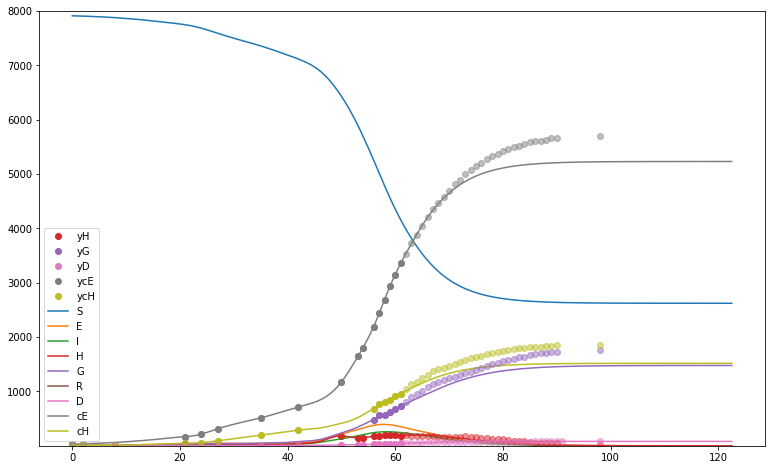

In [20]:
fig, ax=plt.subplots(figsize=[13, 8])
dColours = plt.rcParams['axes.prop_cycle'].by_key()['color']
for clr, data_dots in zip([3,4,6,7,8],[H,G,D,cE,cH]):
    ax.plot(time[start:clip], data_dots[start:clip], 'o', color=dColours[clr])
for clr, data_stripe in zip(dColours, getx(sols[idx]['x'])):
    ax.plot(model.observation_times, data_stripe, color=clr)
for clr, data_dots in zip([3,4,6,7,8],[H,G,D,cE,cH]):
    ax.plot(time, data_dots, 'o', alpha=0.5, color=dColours[clr])
plt.legend(['yH', 'yG', 'yD', 'ycE', 'ycH', 'S', 'E', 'I', 'H', 'G', 'R', 'D', 'cE', 'cH'])
plt.ylim([1e-5, 8000])
# plt.yscale('log')
print(getp(sols[idx]['x']))

In [21]:
solref = sols[idx]['x']

xref = getx(solref)
pref = getp(solref)

In [22]:
regen_params = []
for obs, i, cm in zip(objective.observations, config['observation_vector'], objective.collocation_matrices):
    cmfilter = np.diag(cm) == 1
    comp = ca.interp1d(model.observation_times,xref[i],objective.observation_times).toarray().flatten()[cmfilter]
    delta = np.log(obs[cmfilter]+1) - np.log(comp+1)
    mu = np.mean(delta)
    xd = (np.log(obs[cmfilter]+1) - np.log(comp+1) - mu).reshape(-1,1)
    cov = xd.T@xd
    regen_params.append((comp, mu, cov, cmfilter))
    

(0.9361721277236938, 0.40928125381469727)
(0.8218982219696045, 0.026717042550444603)
(0.9451060891151428, 0.38383814692497253)
(0.9344438910484314, 0.2864150106906891)
(0.9752126336097717, 0.9375079870223999)


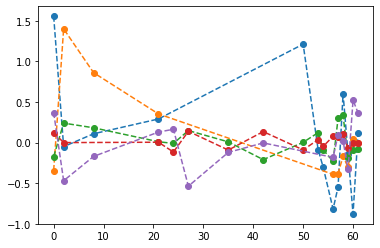

In [49]:
for obs, i, cm in zip(objective.observations, config['observation_vector'], objective.collocation_matrices):
    cmfilter = np.diag(cm) == 1
    comp = ca.interp1d(model.observation_times,xref[i],objective.observation_times).toarray().flatten()[cmfilter]
    delta = np.log(obs[cmfilter]+1) - np.log(comp+1)
    plt.plot(data_time[cmfilter], delta, 'o--')
    print(stats.shapiro(delta))

In [33]:
def resampler(params):
    out = []
    for x, m, cv, ci in params:
        mx = (np.log(x+1)+m)
        temp = np.empty((len(ci)))
        temp[:] = np.nan
        temp[ci] = np.exp(np.random.randn(*mx.shape)*np.sqrt(cv)+mx).flatten() - 1
        out.append(temp)
    return out

In [35]:
yd = [resampler(regen_params) for _ in range(200)]

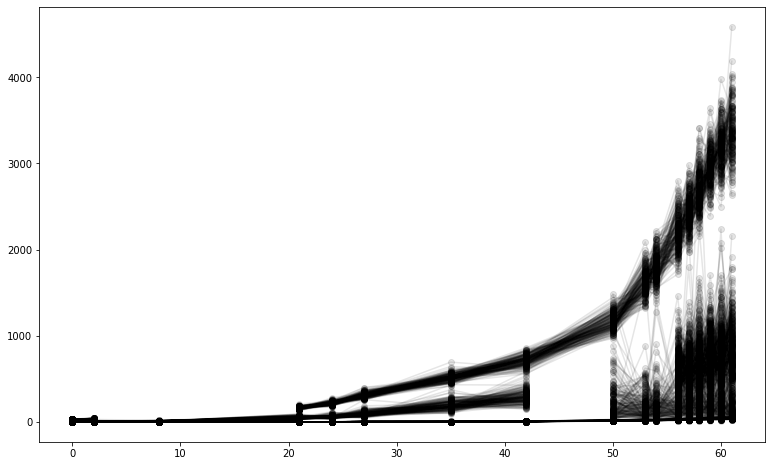

In [37]:
plt.figure(figsize=[13,8])
for y in yd:
    for x in y:
        plt.plot(objective.observation_times, x, 'ko-', alpha=0.1)

In [38]:
rho = prange[idx]
resolves = []
for y in yd:
    # construct problem
    dpd = np.vstack(y).T
    objective.observations = objective.observations_from_pandas(dpd)
    objective.create_objective(model)
    isetup = {
        'f': objective.objective,
        'x': ca.vcat(objective.input_list),
        'p': ca.hcat([objective.rho, objective.alpha]),
        'g': ca.vcat(model.xs),
    }
    isolver = ca.nlpsol('solver', 'ipopt', isetup, ipopt_opts)
    isolve_opts = {
        'x0': solref,
        'p': [rho, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    resolves.append(isolver(**isolve_opts))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

 950 1.1252807e+005 0.00e+000 2.66e+001  -2.5 2.60e+001    -  1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 1.1252762e+005 0.00e+000 6.57e+001  -3.8 5.78e+002    -  9.15e-001 6.12e-001f  1
1050 1.1252731e+005 0.00e+000 1.05e+002  -3.8 3.44e+001    -  1.00e+000 1.00e+000f  1
1100 1.1252723e+005 0.00e+000 6.22e+001  -3.8 3.06e+001    -  1.00e+000 1.00e+000f  1
1150 1.1252716e+005 0.00e+000 1.03e+001  -3.8 1.45e+001    -  1.00e+000 1.00e+000f  1
1200 1.1252711e+005 0.00e+000 4.53e+001  -3.8 1.16e+002    -  1.00e+000 2.50e-001f  3
1250 1.1252706e+005 0.00e+000 6.28e+001  -3.8 1.70e+002    -  1.00e+000 2.50e-001f  3
1300 1.1252702e+005 0.00e+000 2.34e+001  -3.8 3.17e+001    -  1.00e+000 1.00e+000f  1
1350 1.1252699e+005 0.00e+000 6.19e+001  -3.8 2.12e+002    -  1.00e+000 2.50e-001f  3
1400 1.1252696e+005 0.00e+000 3.84e+001  -3.8 4.69e+001    -  1.00e+000 1.00e+000f  1
1450 1.1252693e+005 0.00e+000 7.63e+000  -3.8 2.23e+001    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

 900 4.5056593e+004 0.00e+000 8.01e+001  -3.8 2.07e+000    -  1.00e+000 1.00e+000f  1
 950 4.5056180e+004 0.00e+000 3.85e+002  -3.8 9.99e+000    -  1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.5055853e+004 0.00e+000 2.21e+002  -3.8 4.94e+000    -  1.00e+000 1.00e+000f  1
1050 4.5055594e+004 0.00e+000 4.90e+002  -3.8 8.71e+000    -  1.00e+000 1.00e+000f  1
1100 4.5055376e+004 0.00e+000 3.71e+001  -3.8 2.85e+000    -  1.00e+000 1.00e+000f  1
1150 4.5055203e+004 0.00e+000 1.51e+002  -3.8 6.63e+000    -  1.00e+000 1.00e+000f  1
1200 4.5055060e+004 0.00e+000 1.65e+002  -3.8 1.36e+001    -  1.00e+000 5.00e-001f  2
1250 4.5054941e+004 0.00e+000 1.41e+002  -3.8 8.51e+000    -  1.00e+000 1.00e+000f  1
1300 4.5054841e+004 0.00e+000 1.38e+002  -3.8 9.59e+000    -  1.00e+000 1.00e+000f  1
1350 4.5054757e+004 0.00e+000 1.46e+002  -3.8 1.12e+001    -  1.00e+000 1.00e+000f  1
1400 4.5054685e+004 0.00e+000 8.01e+001  -3.8 9.38e+000    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

 950 6.8629620e+004 0.00e+000 1.30e+001  -3.8 3.45e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 6.8629531e+004 0.00e+000 9.74e+001  -3.8 1.08e+001    -  1.00e+000 1.00e+000f  1
1050 6.8629454e+004 0.00e+000 3.85e+001  -3.8 5.72e+001    -  1.00e+000 1.25e-001f  4
1100 6.8629392e+004 0.00e+000 7.82e+001  -3.8 2.39e+001    -  1.00e+000 5.00e-001f  2
1150 6.8629339e+004 0.00e+000 2.99e+001  -3.8 8.86e+000    -  1.00e+000 1.00e+000f  1
1200 6.8629293e+004 0.00e+000 7.12e+001  -3.8 5.94e+001    -  1.00e+000 2.50e-001f  3
1250 6.8629255e+004 0.00e+000 6.32e+000  -3.8 5.18e+000    -  1.00e+000 1.00e+000f  1
1300 6.8629222e+004 0.00e+000 7.45e+001  -3.8 7.69e+001    -  1.00e+000 2.50e-001f  3
1350 6.8629193e+004 0.00e+000 1.23e+001  -3.8 8.93e+000    -  1.00e+000 1.00e+000f  1
1400 6.8629169e+004 0.00e+000 2.03e+001  -3.8 1.27e+001    -  1.00e+000 1.00e+000f  1
1450 6.8629147e+004 0.00e+000 2.34e+001  -3.8 1.50e+001    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

 100 2.5902414e+004 0.00e+000 2.46e+001  -2.5 5.03e+000  -3.5 1.00e+000 1.00e+000f  1
 150 2.5879506e+004 0.00e+000 5.25e+000  -2.5 2.21e+001  -6.6 1.00e+000 1.00e+000f  1
 200 2.5865915e+004 0.00e+000 1.26e+001  -2.5 2.17e+001    -  1.00e+000 1.00e+000f  1
 250 2.5865136e+004 0.00e+000 9.99e+000  -3.8 2.72e+001    -  1.00e+000 1.00e+000f  1
 300 2.5864879e+004 0.00e+000 1.30e+001  -3.8 4.69e+001    -  1.00e+000 1.00e+000f  1
 350 2.5864786e+004 0.00e+000 7.34e+000  -3.8 4.91e+001    -  1.00e+000 1.00e+000f  1
 400 2.5864746e+004 0.00e+000 1.27e+002  -3.8 3.22e+002    -  1.00e+000 5.00e-001f  2
 450 2.5864725e+004 0.00e+000 1.20e+002  -3.8 3.04e+002    -  1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 2.5864714e+004 0.00e+000 4.64e+000  -3.8 6.70e+001    -  1.00e+000 1.00e+000f  1
 550 2.5864698e+004 0.00e+000 5.93e+001  -5.7 2.67e+002    -  1.00e+000 1.00e+000f  1
 600 2.5864689e+004 0.00e+000 5.27e+001  -5.7 3.04e+002    

 150 1.7246603e+005 0.00e+000 3.16e+001  -1.7 4.23e-001  -2.1 1.00e+000 1.00e+000f  1
 200 1.7244237e+005 0.00e+000 3.35e+002  -1.7 3.83e+000    -  1.00e+000 1.00e+000f  1
 250 1.7243944e+005 0.00e+000 7.72e+001  -1.7 1.24e+000    -  1.00e+000 1.00e+000f  1
 300 1.7243771e+005 0.00e+000 7.77e+001  -1.7 1.58e+000    -  1.00e+000 1.00e+000f  1
 350 1.7243671e+005 0.00e+000 8.46e+001  -1.7 7.52e+000    -  1.00e+000 2.50e-001f  3
 400 1.7242816e+005 0.00e+000 3.44e+002  -2.5 8.39e+000    -  1.00e+000 5.00e-001f  2
 450 1.7242707e+005 0.00e+000 1.91e+002  -2.5 1.60e+001    -  1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.7242633e+005 0.00e+000 2.68e+002  -2.5 7.05e+000    -  1.00e+000 1.00e+000f  1
 550 1.7242581e+005 0.00e+000 2.63e+001  -2.5 2.81e+000    -  1.00e+000 1.00e+000f  1
 600 1.7242543e+005 0.00e+000 5.64e+001  -2.5 4.99e+000    -  1.00e+000 1.00e+000f  1
 650 1.7242515e+005 0.00e+000 1.47e+001  -2.5 3.09e+000    

 200 5.4086786e+004 0.00e+000 9.10e+000  -3.8 2.93e+001  -7.3 1.00e+000 1.00e+000f  1
 250 5.4085212e+004 0.00e+000 2.64e+000  -3.8 1.99e+002  -8.6 1.00e+000 1.00e+000f  1
 300 5.4084069e+004 0.00e+000 1.20e+001  -3.8 5.96e+000  -7.2 1.00e+000 1.00e+000f  1
 350 5.4083334e+004 0.00e+000 7.41e-001  -3.8 1.58e+000  -6.7 1.00e+000 1.00e+000f  1
 400 5.4083093e+004 0.00e+000 2.19e+000  -3.8 2.28e+001  -8.8 1.00e+000 1.00e+000f  1
 450 5.4082946e+004 0.00e+000 3.07e+000  -3.8 4.41e+002 -10.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 5.4082806e+004 0.00e+000 9.29e+000  -3.8 7.16e+000  -7.8 1.00e+000 1.00e+000f  1

Number of Iterations....: 533

                                   (scaled)                 (unscaled)
Objective...............:  5.4082668100414376e+004   5.4082668100414376e+004
Dual infeasibility......:  8.1046851947720773e-009   8.1046851947720773e-009
Constraint violation....:  0.0000000000000000e+000   0.00000

1150 4.5917161e+004 0.00e+000 6.85e+001  -3.8 2.60e+001    -  1.00e+000 5.00e-001f  2
1200 4.5917127e+004 0.00e+000 3.06e+001  -3.8 1.15e+001    -  1.00e+000 1.00e+000f  1
1250 4.5917099e+004 0.00e+000 1.73e+001  -3.8 9.64e+000    -  1.00e+000 1.00e+000f  1
1300 4.5917074e+004 0.00e+000 8.98e+001  -3.8 2.43e+001    -  1.00e+000 1.00e+000f  1
1350 4.5917053e+004 0.00e+000 6.89e+001  -3.8 8.87e+001    -  1.00e+000 2.50e-001f  3
1400 4.5917034e+004 0.00e+000 3.60e+001  -3.8 1.88e+001    -  1.00e+000 1.00e+000f  1
1450 4.5917018e+004 0.00e+000 1.05e+002  -3.8 3.51e+001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 4.5917004e+004 0.00e+000 7.97e+001  -3.8 6.40e+001    -  1.00e+000 5.00e-001f  2
1550 4.5916991e+004 0.00e+000 6.48e+001  -3.8 1.26e+002    -  1.00e+000 2.50e-001f  3
1600 4.5916980e+004 0.00e+000 4.97e+001  -3.8 5.79e+001    -  1.00e+000 5.00e-001f  2
1650 4.5916970e+004 0.00e+000 6.85e+001  -3.8 3.99e+001    

  50 4.4712565e+004 0.00e+000 3.81e+000  -1.7 9.70e+002    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 68

                                   (scaled)                 (unscaled)
Objective...............:  4.4708934442814512e+004   4.4708934442814512e+004
Dual infeasibility......:  5.1329801991635379e-010   5.1329801991635379e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.8688646545564061e-010   9.8688646545564061e-010
Overall NLP error.......:  9.8688646545564061e-010   9.8688646545564061e-010


Number of objective function evaluations             = 86
Number of objective gradient evaluations             = 69
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 86
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 69
Number of Lagrangian Hessian evaluations             = 68
Total CPU secs in IPO


Number of Iterations....: 49

                                   (scaled)                 (unscaled)
Objective...............:  3.7794961899795519e+004   3.7794961899795519e+004
Dual infeasibility......:  6.0767780594409945e-010   6.0767780594409945e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5164325157014586e-009   2.5164325157014586e-009
Overall NLP error.......:  2.5164325157014586e-009   2.5164325157014586e-009


Number of objective function evaluations             = 56
Number of objective gradient evaluations             = 50
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 56
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 50
Number of Lagrangian Hessian evaluations             = 49
Total CPU secs in IPOPT (w/o function evaluations)   =      0.559
Total CPU secs in NLP function evaluation

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

2350 1.1390959e+005 0.00e+000 1.71e+000  -5.7 1.69e+002    -  1.00e+000 1.00e+000h  1
2400 1.1390959e+005 0.00e+000 3.44e+001  -5.7 7.61e+002    -  1.00e+000 1.00e+000h  1
2450 1.1390959e+005 0.00e+000 7.66e+001  -5.7 1.85e+004    -  1.00e+000 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 1.1390959e+005 0.00e+000 1.12e+000  -5.7 1.47e+002    -  1.00e+000 1.00e+000h  1
2550 1.1390959e+005 0.00e+000 4.91e+000  -5.7 3.08e+002    -  1.00e+000 1.00e+000h  1
2600 1.1390959e+005 0.00e+000 4.34e+000  -5.7 2.96e+002    -  1.00e+000 1.00e+000h  1
2650 1.1390959e+005 0.00e+000 1.19e+002  -5.7 1.58e+003    -  1.00e+000 1.00e+000H  1
2700 1.1390959e+005 0.00e+000 9.80e+000  -5.7 4.60e+002    -  1.00e+000 1.00e+000h  1
2750 1.1390959e+005 0.00e+000 4.23e+000  -5.7 3.05e+002    -  1.00e+000 1.00e+000h  1
2800 1.1390959e+005 0.00e+000 4.93e+001  -8.6 1.06e+003    -  1.00e+000 1.00e+000h  1
2850 1.1390959e+005 0.00e+000 9.02e+001  -8.6 2.31e+004    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

2450 1.9702297e+005 0.00e+000 3.18e-002  -5.7 6.29e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 1.9702297e+005 0.00e+000 2.04e+000  -5.7 3.79e+001    -  1.00e+000 1.00e+000h  1
2550 1.9702297e+005 0.00e+000 3.31e+000  -5.7 4.99e+001    -  1.00e+000 1.00e+000h  1
2600 1.9702296e+005 0.00e+000 5.20e+001  -8.6 1.84e+002    -  1.00e+000 5.52e-001f  1
2650 1.9702296e+005 0.00e+000 1.56e+003  -8.6 2.63e+003    -  1.00e+000 6.25e-002h  5
2700 1.9702296e+005 0.00e+000 7.03e-001  -8.6 2.67e+001    -  1.00e+000 1.00e+000f  1
2750 1.9702296e+005 0.00e+000 5.21e+001  -8.6 2.27e+002    -  1.00e+000 1.00e+000h  1
2800 1.9702295e+005 0.00e+000 2.62e+000  -8.6 5.35e+001    -  1.00e+000 1.00e+000h  1
2850 1.9702295e+005 0.00e+000 3.53e+001  -8.6 2.01e+002    -  1.00e+000 1.00e+000h  1
2900 1.9702295e+005 0.00e+000 3.38e+003  -8.6 5.51e+003    -  1.00e+000 3.12e-002h  6
2950 1.9702295e+005 0.00e+000 1.07e+001  -8.6 1.19e+002    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

2450 5.1569048e+004 0.00e+000 1.64e+001  -3.8 1.28e+002    -  1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 5.1569045e+004 0.00e+000 1.52e+001  -3.8 1.95e+001    -  1.00e+000 1.00e+000h  1
2550 5.1569043e+004 0.00e+000 2.73e+000  -3.8 8.49e+000    -  1.00e+000 1.00e+000h  1
2600 5.1569041e+004 0.00e+000 1.49e+001  -3.8 2.03e+001    -  1.00e+000 1.00e+000h  1
2650 5.1569038e+004 0.00e+000 9.80e-001  -3.8 5.41e+000    -  1.00e+000 1.00e+000h  1
2700 5.1569036e+004 0.00e+000 1.99e+001  -3.8 4.70e+001    -  1.00e+000 5.00e-001h  2
2750 5.1569035e+004 0.00e+000 1.84e+001  -3.8 2.43e+001    -  1.00e+000 1.00e+000h  1
2800 5.1569033e+004 0.00e+000 8.64e-001  -3.8 5.40e+000    -  1.00e+000 1.00e+000h  1
2850 5.1569032e+004 0.00e+000 6.22e-001  -3.8 4.68e+000    -  1.00e+000 1.00e+000h  1
2900 5.1569030e+004 0.00e+000 1.65e-001  -3.8 2.50e+000    -  1.00e+000 1.00e+000h  1
2950 5.1569030e+004 0.00e+000 3.22e+002  -3.8 1.09e+002    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

  50 8.8452310e+004 0.00e+000 2.58e+000  -2.5 4.89e+002 -10.8 1.00e+000 1.00e+000f  1

Number of Iterations....: 90

                                   (scaled)                 (unscaled)
Objective...............:  8.8448075834532283e+004   8.8448075834532283e+004
Dual infeasibility......:  6.3655625914188574e-010   6.3655625914188574e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5131653968623920e-009   2.5131653968623920e-009
Overall NLP error.......:  2.5131653968623920e-009   2.5131653968623920e-009


Number of objective function evaluations             = 145
Number of objective gradient evaluations             = 91
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 145
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 91
Number of Lagrangian Hessian evaluations             = 90
Total CPU secs in I

1500 4.5318410e+004 0.00e+000 3.97e+002  -3.8 7.96e+001    -  1.00e+000 5.00e-001f  2
1550 4.5318398e+004 0.00e+000 3.10e+001  -3.8 3.16e+001    -  1.00e+000 1.00e+000f  1
1600 4.5318387e+004 0.00e+000 1.73e+003  -3.8 2.31e+002    -  1.00e+000 2.50e-001f  3
1650 4.5318377e+004 0.00e+000 9.92e+000  -3.8 1.98e+001    -  1.00e+000 1.00e+000f  1
1700 4.5318368e+004 0.00e+000 3.37e+001  -3.8 3.78e+001    -  1.00e+000 1.00e+000f  1
1750 4.5318360e+004 0.00e+000 1.88e+001  -3.8 2.95e+001    -  1.00e+000 1.00e+000f  1
1800 4.5318354e+004 0.00e+000 6.03e+001  -3.8 5.49e+001    -  1.00e+000 1.00e+000f  1
1850 4.5318347e+004 0.00e+000 1.70e+001  -3.8 3.04e+001    -  1.00e+000 1.00e+000f  1
1900 4.5318342e+004 0.00e+000 6.84e+002  -3.8 1.37e+002    -  1.00e+000 5.00e-001f  2
1950 4.5318337e+004 0.00e+000 3.82e+001  -3.8 4.90e+001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 4.5318333e+004 0.00e+000 9.19e+001  -3.8 7.85e+001    

  50 6.9740526e+004 0.00e+000 4.40e-001  -2.5 4.19e+002  -8.8 1.00e+000 1.00e+000f  1

Number of Iterations....: 87

                                   (scaled)                 (unscaled)
Objective...............:  6.9730485557153908e+004   6.9730485557153908e+004
Dual infeasibility......:  9.6009839309014172e-010   9.6009839309014172e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.3015056312275100e-010   9.3015056312275100e-010
Overall NLP error.......:  9.6009839309014172e-010   9.6009839309014172e-010


Number of objective function evaluations             = 102
Number of objective gradient evaluations             = 88
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 102
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 88
Number of Lagrangian Hessian evaluations             = 87
Total CPU secs in I

  50 2.9873681e+004 0.00e+000 2.86e+001  -1.0 3.35e+001    -  8.31e-001 1.00e+000f  1
 100 2.9021935e+004 0.00e+000 4.23e+002  -1.7 1.54e+004    -  6.75e-001 1.07e-001f  4
 150 2.8955905e+004 0.00e+000 3.07e+002  -2.5 6.19e+004    -  1.00e+000 5.31e-002f  3
 200 2.8944574e+004 0.00e+000 6.93e-008  -8.6 4.36e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 201

                                   (scaled)                 (unscaled)
Objective...............:  2.8944574195966910e+004   2.8944574195966910e+004
Dual infeasibility......:  5.3910133633130205e-009   5.3910133633130205e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.7085455863825342e-009   2.7085455863825342e-009
Overall NLP error.......:  5.3910133633130205e-009   5.3910133633130205e-009


Number of objective function evaluations             = 358
Number of objective gradient evaluations             = 202
Number of equality constraint evaluations       

  50 6.3094681e+004 0.00e+000 3.61e+001  -2.5 1.83e+003    -  1.00e+000 3.57e-001f  1

Number of Iterations....: 70

                                   (scaled)                 (unscaled)
Objective...............:  6.3093629152574758e+004   6.3093629152574758e+004
Dual infeasibility......:  4.0860306842126534e-009   4.0860306842126534e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  4.2135050241649003e-009   4.2135050241649003e-009
Overall NLP error.......:  4.2135050241649003e-009   4.2135050241649003e-009


Number of objective function evaluations             = 115
Number of objective gradient evaluations             = 71
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 115
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 71
Number of Lagrangian Hessian evaluations             = 70
Total CPU secs in I

  50 3.5654887e+004 0.00e+000 7.90e+002  -1.7 2.16e+004    -  8.69e-001 1.05e-001f  4
 100 3.5547517e+004 0.00e+000 4.25e+001  -2.5 1.82e+003    -  8.57e-001 1.00e+000f  1

Number of Iterations....: 132

                                   (scaled)                 (unscaled)
Objective...............:  3.5547044080994550e+004   3.5547044080994550e+004
Dual infeasibility......:  6.2889710359117228e-009   6.2889710359117228e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  3.5119030659699397e-009   3.5119030659699397e-009
Overall NLP error.......:  6.2889710359117228e-009   6.2889710359117228e-009


Number of objective function evaluations             = 282
Number of objective gradient evaluations             = 133
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 282
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 2.6745586e+004 0.00e+000 4.92e+002  -1.7 2.59e+001  -5.1 1.00e+000 1.00e+000f  1
 100 2.6728290e+004 0.00e+000 4.54e+000  -2.5 1.82e+001  -6.8 1.00e+000 1.00e+000f  1
 150 2.6724674e+004 0.00e+000 4.70e-001  -2.5 1.25e+001  -7.1 1.00e+000 1.00e+000f  1
 200 2.6722758e+004 0.00e+000 1.05e+001  -2.5 3.42e+001  -7.5 1.00e+000 1.00e+000f  1
 250 2.6720980e+004 0.00e+000 2.64e+002  -2.5 4.98e+003    -  1.00e+000 2.50e-001f  3
 300 2.6720097e+004 0.00e+000 2.02e-004  -8.6 1.28e+000    -  1.00e+000 5.08e-001h  1

Number of Iterations....: 303

                                   (scaled)                 (unscaled)
Objective...............:  2.5190633557239300e+004   2.6720097163406452e+004
Dual infeasibility......:  7.0699141256945204e-010   7.4991679723437771e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5716155166587004e-009   2.7277526115375187e-009
Overall NLP error.......:  2.5716155166587004e-009   2.7277526115375187e-

1200 7.5182167e+004 0.00e+000 1.68e+001  -3.8 1.78e+001    -  1.00e+000 1.00e+000f  1
1250 7.5182134e+004 0.00e+000 8.89e+000  -3.8 1.47e+001    -  1.00e+000 1.00e+000f  1
1300 7.5182106e+004 0.00e+000 2.73e+001  -3.8 2.73e+001    -  1.00e+000 1.00e+000f  1
1350 7.5182082e+004 0.00e+000 7.66e+000  -3.8 1.54e+001    -  1.00e+000 1.00e+000f  1
1400 7.5182062e+004 0.00e+000 7.90e+000  -3.8 1.66e+001    -  1.00e+000 1.00e+000f  1
1450 7.5182044e+004 0.00e+000 1.40e+002  -3.8 6.05e+001    -  1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 7.5182029e+004 0.00e+000 5.70e+001  -3.8 4.89e+001    -  1.00e+000 1.00e+000f  1
1550 7.5182016e+004 0.00e+000 1.00e+001  -3.8 2.17e+001    -  1.00e+000 1.00e+000f  1
1600 7.5182004e+004 0.00e+000 1.73e+001  -3.8 2.98e+001    -  1.00e+000 1.00e+000f  1
1650 7.5181994e+004 0.00e+000 1.14e+001  -3.8 2.53e+001    -  1.00e+000 1.00e+000f  1
1700 7.5181985e+004 0.00e+000 3.68e+001  -3.8 4.72e+001    

  50 5.4683510e+004 0.00e+000 4.12e+001  -2.5 3.39e+002  -6.7 1.00e+000 1.00e+000f  1

Number of Iterations....: 84

                                   (scaled)                 (unscaled)
Objective...............:  5.4645176892484531e+004   5.4645176892484531e+004
Dual infeasibility......:  9.8601959613810481e-010   9.8601959613810481e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  3.1349986693697538e-009   3.1349986693697538e-009
Overall NLP error.......:  3.1349986693697538e-009   3.1349986693697538e-009


Number of objective function evaluations             = 96
Number of objective gradient evaluations             = 85
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 96
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 85
Number of Lagrangian Hessian evaluations             = 84
Total CPU secs in IPO

  50 9.2658783e+004 0.00e+000 5.81e+000  -2.5 1.60e+002  -8.2 1.00e+000 1.00e+000f  1
 100 9.2639032e+004 0.00e+000 3.78e-007  -5.7 1.43e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 108

                                   (scaled)                 (unscaled)
Objective...............:  9.2639031476517266e+004   9.2639031476517266e+004
Dual infeasibility......:  5.3041429635406285e-010   5.3041429635406285e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.9596922416564997e-009   2.9596922416564997e-009
Overall NLP error.......:  2.9596922416564997e-009   2.9596922416564997e-009


Number of objective function evaluations             = 147
Number of objective gradient evaluations             = 109
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 147
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 5.0094892e+004 0.00e+000 8.43e-001  -1.0 3.12e-001  -0.8 1.00e+000 1.00e+000f  1
 100 5.0044402e+004 0.00e+000 9.06e+001  -1.7 2.96e+002  -8.4 1.00e+000 1.00e+000f  1
 150 5.0038047e+004 0.00e+000 1.60e+002  -1.7 7.00e+003    -  1.00e+000 1.25e-001f  4
 200 5.0035193e+004 0.00e+000 5.62e+001  -1.7 5.53e+002    -  1.00e+000 1.00e+000f  1
 250 5.0033781e+004 0.00e+000 4.11e+000  -1.7 1.04e+001    -  1.00e+000 1.00e+000f  1
 300 5.0029712e+004 0.00e+000 1.65e+002  -2.5 1.10e+003    -  1.00e+000 1.00e+000f  1
 350 5.0028665e+004 0.00e+000 6.85e+001  -2.5 4.60e+002    -  1.00e+000 5.00e-001f  2
 400 5.0027822e+004 0.00e+000 4.82e+001  -3.8 2.52e+003    -  1.00e+000 1.00e+000f  1
 450 5.0027335e+004 0.00e+000 5.67e+001  -3.8 1.80e+003    -  1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 5.0027044e+004 0.00e+000 3.19e+001  -3.8 1.79e+003    -  1.00e+000 5.00e-001f  2
 550 5.0026819e+004 0.00e+000 3.14e+001  -3.8 1.32e+003    

  50 5.2338612e+004 0.00e+000 3.17e+000  -1.7 2.72e+000  -4.6 1.00e+000 1.00e+000f  1
 100 5.2333515e+004 0.00e+000 4.60e+001  -3.8 4.33e+001  -6.7 1.00e+000 1.00e+000f  1
 150 5.2332311e+004 0.00e+000 8.00e-001  -3.8 1.10e+000  -6.2 1.00e+000 1.00e+000f  1
 200 5.2331887e+004 0.00e+000 1.01e+002  -3.8 6.47e+002  -6.1 1.00e+000 1.42e-002f  6
 250 5.2331535e+004 0.00e+000 6.27e+001  -3.8 3.91e+001  -6.4 1.00e+000 1.25e-001f  4

Number of Iterations....: 277

                                   (scaled)                 (unscaled)
Objective...............:  5.2331404664274392e+004   5.2331404664274392e+004
Dual infeasibility......:  9.2515061691389059e-011   9.2515061691389059e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035817927833e-009   2.5059035817927833e-009
Overall NLP error.......:  2.5059035817927833e-009   2.5059035817927833e-009


Number of objective function evaluations             = 531
Number of objective g

  50 2.8428241e+004 0.00e+000 4.72e+002  -1.7 3.73e+004    -  6.26e-001 1.32e-001f  3
 100 2.8341639e+004 0.00e+000 5.70e+002  -3.8 3.19e+004    -  1.00e+000 7.77e-002f  3
 150 2.8322323e+004 0.00e+000 3.74e+001  -3.8 5.77e-001  -2.3 1.00e+000 1.00e+000f  1
 200 2.8317537e+004 0.00e+000 2.70e+002  -3.8 1.26e+001    -  1.00e+000 2.50e-001f  3
 250 2.8314735e+004 0.00e+000 1.56e+002  -3.8 2.84e+000    -  1.00e+000 1.00e+000f  1
 300 2.8313055e+004 0.00e+000 3.11e+001  -3.8 1.88e+000    -  1.00e+000 1.00e+000f  1
 350 2.8311997e+004 0.00e+000 1.15e+002  -3.8 5.03e+000    -  1.00e+000 1.00e+000f  1
 400 2.8311295e+004 0.00e+000 2.11e+001  -3.8 2.96e+000    -  1.00e+000 1.00e+000f  1
 450 2.8310825e+004 0.00e+000 1.30e+002  -3.8 9.58e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 2.8310487e+004 0.00e+000 9.52e+001  -3.8 1.05e+001    -  1.00e+000 1.00e+000f  1
 550 2.8310238e+004 0.00e+000 8.76e+000  -3.8 4.11e+000    

 100 3.3891434e+004 0.00e+000 3.44e-007  -8.6 2.92e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 102

                                   (scaled)                 (unscaled)
Objective...............:  3.3891434238022724e+004   3.3891434238022724e+004
Dual infeasibility......:  1.6925766477411920e-009   1.6925766477411920e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6275452356165524e-009   2.6275452356165524e-009
Overall NLP error.......:  2.6275452356165524e-009   2.6275452356165524e-009


Number of objective function evaluations             = 140
Number of objective gradient evaluations             = 103
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 140
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 103
Number of Lagrangian Hessian evaluations             = 102
Total CPU secs 

  50 2.9657251e+004 0.00e+000 6.88e+002  -1.0 1.45e+004    -  7.54e-001 1.25e-001f  4
 100 2.9616103e+004 0.00e+000 4.38e+001  -2.5 8.84e-001  -1.7 1.00e+000 1.00e+000f  1
 150 2.9606102e+004 0.00e+000 3.38e+002  -2.5 1.21e+006    -  2.31e-002 1.53e-003f  4
 200 2.9601712e+004 0.00e+000 3.78e+002  -2.5 5.84e+000  -4.3 1.00e+000 5.00e-001f  2
 250 2.9599316e+004 0.00e+000 2.68e+002  -2.5 7.75e+004    -  2.01e-001 1.04e-002f  5
 300 2.9598306e+004 0.00e+000 1.60e+002  -2.5 7.93e+002    -  1.00e+000 2.50e-001f  3
 350 2.9597909e+004 0.00e+000 1.19e+002  -2.5 1.65e+002    -  1.00e+000 2.50e-001f  3
 400 2.9597608e+004 0.00e+000 3.82e+001  -2.5 1.44e+000  -5.9 1.00e+000 1.00e+000f  1
 450 2.9597386e+004 0.00e+000 1.60e+001  -2.5 1.69e+003    -  1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 2.9597228e+004 0.00e+000 7.60e+001  -2.5 2.00e+002    -  1.00e+000 1.00e+000f  1
 550 2.9597103e+004 0.00e+000 4.70e+001  -2.5 5.46e+000  -4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

In [39]:
finals = []
for resolve in resolves:
    final_count = getx(resolve['x'])[-2][-1]
    final_dead = getx(resolve['x'])[-3][-1]
    finals.append((final_count, final_dead))
finals = np.vstack(finals)

{'bodies': [<matplotlib.collections.PolyCollection at 0x2dfe6b2f048>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x2dfe6b7bf08>,
 'cmins': <matplotlib.collections.LineCollection at 0x2dfe6b9b0c8>,
 'cbars': <matplotlib.collections.LineCollection at 0x2dfe6b9b388>}

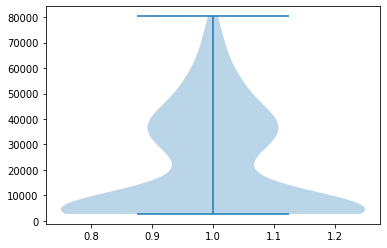

In [40]:
plt.violinplot(finals[:,0])

{'bodies': [<matplotlib.collections.PolyCollection at 0x2dfe7d549c8>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x2dfe7d54688>,
 'cmins': <matplotlib.collections.LineCollection at 0x2dfe7d5c908>,
 'cbars': <matplotlib.collections.LineCollection at 0x2dfe7d5cdc8>}

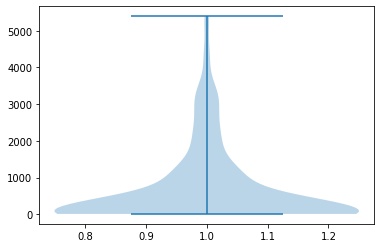

In [41]:
plt.violinplot(finals[:,1])

In [42]:
ci_0 = sorted(finals[:,0])
print(ci_0[4], ci_0[-5])

2893.5440526975913 67291.94021006164


In [43]:
ci_1 = sorted(finals[:,1])
print(ci_1[4], ci_1[-5])

20.187092856909906 3898.1722148319177


In [ ]:
# do GP reg

In [50]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

In [162]:
gps = []
for obs, i, cm in zip(objective.observations, config['observation_vector'], objective.collocation_matrices):
    cmfilter = np.diag(cm) == 1
    comp = ca.interp1d(model.observation_times,xref[i],objective.observation_times).toarray().flatten()[cmfilter]
    delta = (np.log(obs[cmfilter]+1) - np.log(comp+1)).reshape(-1,1)
    gptime = data_time[cmfilter].reshape(-1,1)
    plt.plot(gptime, delta)
    gp = gaussian_process.GaussianProcessRegressor(alpha=0.35, kernel=kernel)
    gp.fit(gptime, delta)
    gps.append((gp, gptime, comp, cmfilter))
    

In [168]:
def resample_gp(gps):
    out = []
    for gp, t, x, c in gps:
        temp = np.empty((len(c)))
        temp[:] = np.nan
        y = gp.sample_y(t, random_state=None).flatten()
        temp[c] = np.exp(y+np.log(x+1)).flatten() - 1
        out.append(temp)
    return out

<IPython.core.display.Javascript object>


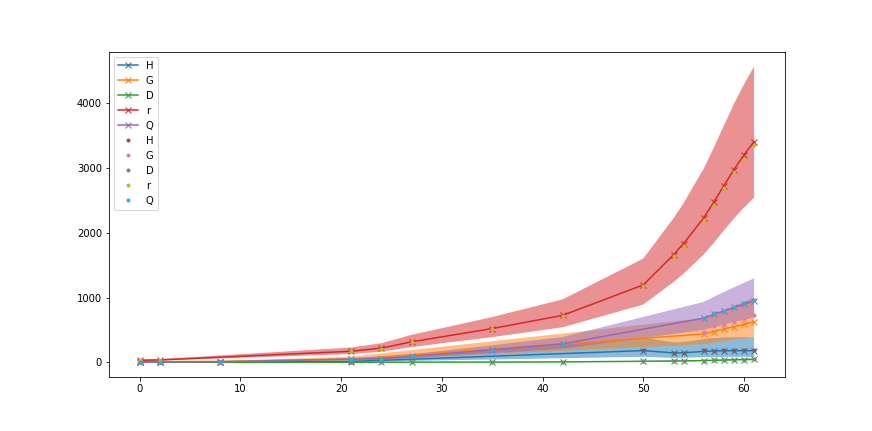

In [169]:
plt.figure()
def GP2Y(x, y):
    return np.exp(y+np.log(x+1)).flatten() - 1
for gp, t, x, c in gps:
    y,s = gp.predict(t, return_std=True)
    y=y.flatten(); s=s.flatten()
    temp = GP2Y(x, y)
    plt.plot(data_time[c], temp, 'x-')
    plt.fill(np.concatenate([data_time[c], data_time[c][::-1]]),
             np.concatenate([GP2Y(x, y - 2*s),
                             GP2Y(x, (y + 2*s))[::-1]]),
         alpha=.5, label='95% CI')
plt.plot(data_time, data_pd, '.')
plt.legend('HGDrQHGDrQ')

In [170]:
yg = [resample_gp(gps) for _ in range(500)]

<IPython.core.display.Javascript object>


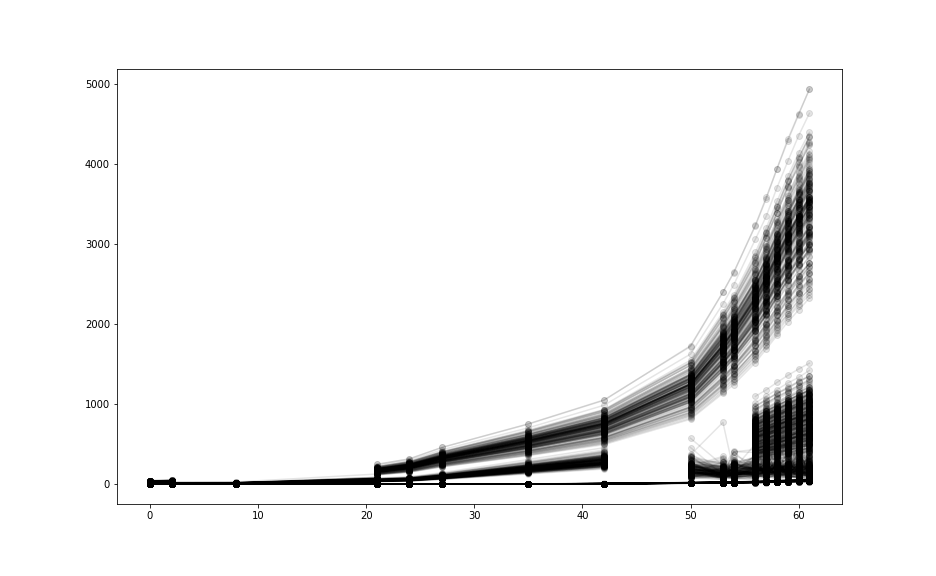

In [171]:
plt.figure(figsize=[13,8])
for y in yg:
    for x in y:
        plt.plot(objective.observation_times, x, 'ko-', alpha=0.1)

In [172]:
gpresolves = []
for y in yg:
    # construct problem
    dpd = np.vstack(y).T
    objective.observations = objective.observations_from_pandas(dpd)
    objective.create_objective(model)
    isetup = {
        'f': objective.objective,
        'x': ca.vcat(objective.input_list),
        'p': ca.hcat([objective.rho, objective.alpha]),
        'g': ca.vcat(model.xs),
    }
    isolver = ca.nlpsol('solver', 'ipopt', isetup, ipopt_opts)
    isolve_opts = {
        'x0': solref,
        'p': [rho, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    gpresolves.append(isolver(**isolve_opts))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

  50 2.2152208e+003 0.00e+000 1.05e+000  -5.7 1.10e+003    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 59

                                   (scaled)                 (unscaled)
Objective...............:  2.2152201171658990e+003   2.2152201171658990e+003
Dual infeasibility......:  7.0884627322358263e-011   7.0884627322358263e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.0060965046703775e-009   1.0060965046703775e-009
Overall NLP error.......:  1.0060965046703775e-009   1.0060965046703775e-009


Number of objective function evaluations             = 101
Number of objective gradient evaluations             = 60
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 101
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 60
Number of Lagrangian Hessian evaluations             = 59
Total CPU secs in I

  50 4.8229338e+002 0.00e+000 1.09e-004  -5.7 8.19e+000  -9.1 1.00e+000 1.00e+000h  1
 100 4.8155653e+002 0.00e+000 4.36e+001  -5.7 1.98e+003    -  1.00e+000 2.20e-001f  3

Number of Iterations....: 118

                                   (scaled)                 (unscaled)
Objective...............:  4.8090942217899948e+002   4.8122780379978764e+002
Dual infeasibility......:  9.2353040645927446e-010   9.2414182119580302e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5613809698038842e-009   2.5630767083089172e-009
Overall NLP error.......:  2.5613809698038842e-009   2.5630767083089172e-009


Number of objective function evaluations             = 237
Number of objective gradient evaluations             = 115
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 237
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3


Number of Iterations....: 43

                                   (scaled)                 (unscaled)
Objective...............:  5.7609484949622743e+002   6.0109424566933126e+002
Dual infeasibility......:  5.1727451986890520e-011   5.3972143232396876e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  6.1045751852606657e-009   6.3694806841698856e-009
Overall NLP error.......:  6.1045751852606657e-009   6.3694806841698856e-009


Number of objective function evaluations             = 60
Number of objective gradient evaluations             = 44
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 60
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 44
Number of Lagrangian Hessian evaluations             = 43
Total CPU secs in IPOPT (w/o function evaluations)   =      0.467
Total CPU secs in NLP function evaluation


Number of Iterations....: 128

                                   (scaled)                 (unscaled)
Objective...............:  3.7204471218332611e+002   6.0398393277583909e+002
Dual infeasibility......:  6.5933753180055063e-009   1.0703801517474137e-008
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1758995178934297e-009   1.9089759701154457e-009
Overall NLP error.......:  6.5933753180055063e-009   1.0703801517474137e-008


Number of objective function evaluations             = 256
Number of objective gradient evaluations             = 129
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 256
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 129
Number of Lagrangian Hessian evaluations             = 128
Total CPU secs in IPOPT (w/o function evaluations)   =      1.423
Total CPU secs in NLP function eval

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

 100 2.8582404e+003 0.00e+000 9.92e-001  -5.7 5.96e+000  -7.5 1.00e+000 1.00e+000f  1

Number of Iterations....: 110

                                   (scaled)                 (unscaled)
Objective...............:  2.0726685087010983e+003   2.8582369514959469e+003
Dual infeasibility......:  1.0038342881418617e-009   1.3843005977563527e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5282607545020992e-009   3.4865046104567629e-009
Overall NLP error.......:  2.5282607545020992e-009   3.4865046104567629e-009


Number of objective function evaluations             = 224
Number of objective gradient evaluations             = 111
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 224
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 111
Number of Lagrangian Hessian evaluations             = 110
Total CPU secs 

 100 2.1002855e+003 0.00e+000 3.21e-001  -3.8 2.71e+002 -11.1 1.00e+000 1.00e+000f  1

Number of Iterations....: 127

                                   (scaled)                 (unscaled)
Objective...............:  8.7448169417003112e+002   2.1002426299904655e+003
Dual infeasibility......:  1.1960674836984316e-009   2.8725952005125012e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.3083072782417271e-009   2.2355761005801708e-008
Overall NLP error.......:  9.3083072782417271e-009   2.2355761005801708e-008


Number of objective function evaluations             = 290
Number of objective gradient evaluations             = 128
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 290
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 128
Number of Lagrangian Hessian evaluations             = 127
Total CPU secs 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

  50 1.7312774e+002 0.00e+000 2.14e-001  -8.6 1.22e+003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 72

                                   (scaled)                 (unscaled)
Objective...............:  1.7312747777420051e+002   1.7312747777420051e+002
Dual infeasibility......:  7.5786832347033529e-011   7.5786832347033529e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5060491722627185e-009   2.5060491722627185e-009
Overall NLP error.......:  2.5060491722627185e-009   2.5060491722627185e-009


Number of objective function evaluations             = 114
Number of objective gradient evaluations             = 73
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 114
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 73
Number of Lagrangian Hessian evaluations             = 72
Total CPU secs in I

  50 3.7468238e+002 0.00e+000 4.24e-001  -2.5 2.14e+000  -5.2 1.00e+000 1.00e+000f  1

Number of Iterations....: 95

                                   (scaled)                 (unscaled)
Objective...............:  9.9121151561153454e+001   3.6875377252248347e+002
Dual infeasibility......:  2.0417571657843619e-009   7.5958122519721437e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  7.9266729006151283e-009   2.9489069584206825e-008
Overall NLP error.......:  7.9266729006151283e-009   2.9489069584206825e-008


Number of objective function evaluations             = 183
Number of objective gradient evaluations             = 96
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 183
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 96
Number of Lagrangian Hessian evaluations             = 95
Total CPU secs in I

  50 5.3183726e+002 0.00e+000 1.76e+001  -2.5 2.06e+002  -6.5 1.00e+000 1.00e+000f  1
 100 5.0896811e+002 0.00e+000 7.66e+001  -3.8 5.52e+002  -7.7 1.00e+000 1.00e+000f  1
 150 5.0490701e+002 0.00e+000 1.37e-001  -8.6 1.95e+003    -  9.82e-001 8.42e-001f  1

Number of Iterations....: 156

                                   (scaled)                 (unscaled)
Objective...............:  5.0490697406769664e+002   5.0490697406769664e+002
Dual infeasibility......:  9.2476881539249151e-011   9.2476881539249151e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.4744474120445894e-010   9.4744474120445894e-010
Overall NLP error.......:  9.4744474120445894e-010   9.4744474120445894e-010


Number of objective function evaluations             = 284
Number of objective gradient evaluations             = 157
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 284
Number of equality

  50 6.5979531e+003 0.00e+000 2.78e+002  -1.7 1.05e+002  -6.2 1.00e+000 1.00e+000f  1
 100 6.5581261e+003 0.00e+000 9.28e-001  -2.5 7.21e+000  -5.7 1.00e+000 1.00e+000f  1

Number of Iterations....: 117

                                   (scaled)                 (unscaled)
Objective...............:  6.5578475844315635e+003   6.5578475844315635e+003
Dual infeasibility......:  6.9024254935740626e-009   6.9024254935740626e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5124402161355481e-009   2.5124402161355481e-009
Overall NLP error.......:  6.9024254935740626e-009   6.9024254935740626e-009


Number of objective function evaluations             = 190
Number of objective gradient evaluations             = 118
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 190
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 6.7759285e+003 0.00e+000 5.72e+000  -3.8 1.30e+002  -8.2 1.00e+000 1.00e+000f  1
 100 6.7749574e+003 0.00e+000 2.38e+001  -3.8 4.88e+003  -8.3 1.00e+000 3.90e-002f  1

Number of Iterations....: 115

                                   (scaled)                 (unscaled)
Objective...............:  6.7748813952589098e+003   6.7748813952589098e+003
Dual infeasibility......:  1.4782543959799701e-009   1.4782543959799701e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5848771586196490e-009   2.5848771586196490e-009
Overall NLP error.......:  2.5848771586196490e-009   2.5848771586196490e-009


Number of objective function evaluations             = 228
Number of objective gradient evaluations             = 116
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 228
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua


Number of Iterations....: 196

                                   (scaled)                 (unscaled)
Objective...............:  2.7815184070295331e+003   2.7815184070295331e+003
Dual infeasibility......:  1.5930548404679097e-010   1.5930548404679097e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  3.9287977924661937e-009   3.9287977924661937e-009
Overall NLP error.......:  3.9287977924661937e-009   3.9287977924661937e-009


Number of objective function evaluations             = 407
Number of objective gradient evaluations             = 197
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 407
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 197
Number of Lagrangian Hessian evaluations             = 196
Total CPU secs in IPOPT (w/o function evaluations)   =      2.396
Total CPU secs in NLP function eval

  50 8.0060500e+002 0.00e+000 6.03e-002  -3.8 3.29e+000  -7.9 1.00e+000 1.00e+000f  1
 100 8.0024677e+002 0.00e+000 2.59e-002  -5.7 1.51e+000  -6.4 1.00e+000 1.00e+000f  1

Number of Iterations....: 119

                                   (scaled)                 (unscaled)
Objective...............:  3.2152960062461011e+002   8.0010255388330222e+002
Dual infeasibility......:  7.9976525639235499e-009   1.9901564985108223e-008
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.9539980386898132e-009   7.3508049346952758e-009
Overall NLP error.......:  7.9976525639235499e-009   1.9901564985108223e-008


Number of objective function evaluations             = 209
Number of objective gradient evaluations             = 120
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 209
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 1.5745756e+003 0.00e+000 1.00e+001  -2.5 2.12e+001  -5.9 1.00e+000 1.00e+000f  1
 100 1.5735359e+003 0.00e+000 1.94e-001  -5.7 8.80e+001  -8.7 1.00e+000 1.00e+000f  1

Number of Iterations....: 128

                                   (scaled)                 (unscaled)
Objective...............:  1.5732925862669686e+003   1.5732925862669686e+003
Dual infeasibility......:  4.7173361930592232e-009   4.7173361930592232e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6966652089328133e-009   2.6966652089328133e-009
Overall NLP error.......:  4.7173361930592232e-009   4.7173361930592232e-009


Number of objective function evaluations             = 238
Number of objective gradient evaluations             = 129
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 238
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 1.3784139e+003 0.00e+000 6.84e-001  -2.5 1.76e+001  -5.7 1.00e+000 1.00e+000f  1
 100 1.3534763e+003 0.00e+000 6.64e-003  -3.8 3.89e-001  -6.4 1.00e+000 1.00e+000f  1

Number of Iterations....: 119

                                   (scaled)                 (unscaled)
Objective...............:  4.6310276086281266e+002   1.3534358536919365e+003
Dual infeasibility......:  2.2639160320950500e-009   6.6163827697263699e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.3498602919313166e-009   3.9450192721181266e-009
Overall NLP error.......:  2.2639160320950500e-009   6.6163827697263699e-009


Number of objective function evaluations             = 214
Number of objective gradient evaluations             = 120
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 214
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

 100 1.9863516e+003 0.00e+000 6.25e-002  -5.7 7.63e+000  -7.3 1.00e+000 1.00e+000f  1

Number of Iterations....: 121

                                   (scaled)                 (unscaled)
Objective...............:  8.2534407738131040e+002   1.9858819998133044e+003
Dual infeasibility......:  5.8856463903859547e-009   1.4161607921169643e-008
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6423874386609176e-009   6.3579176185754077e-009
Overall NLP error.......:  5.8856463903859547e-009   1.4161607921169643e-008


Number of objective function evaluations             = 267
Number of objective gradient evaluations             = 122
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 267
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 122
Number of Lagrangian Hessian evaluations             = 121
Total CPU secs 

  50 1.3271658e+003 0.00e+000 3.50e-001  -5.7 2.12e+002 -10.0 1.00e+000 1.00e+000f  1
 100 1.3257450e+003 0.00e+000 1.95e+000  -5.7 2.73e+002  -9.0 1.00e+000 1.00e+000f  1

Number of Iterations....: 136

                                   (scaled)                 (unscaled)
Objective...............:  3.2025394665015534e+002   1.3243986149057646e+003
Dual infeasibility......:  7.2946868108236959e-009   3.0166913505612426e-008
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6257371832004630e-009   1.0858641165587554e-008
Overall NLP error.......:  7.2946868108236959e-009   3.0166913505612426e-008


Number of objective function evaluations             = 212
Number of objective gradient evaluations             = 137
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 212
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua


Number of Iterations....: 115

                                   (scaled)                 (unscaled)
Objective...............:  6.4792666057033625e+002   8.6435160350745343e+002
Dual infeasibility......:  3.4519215132075886e-009   4.6049562036797202e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6203089029280631e-009   3.4955625995341528e-009
Overall NLP error.......:  3.4519215132075886e-009   4.6049562036797202e-009


Number of objective function evaluations             = 203
Number of objective gradient evaluations             = 116
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 203
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 116
Number of Lagrangian Hessian evaluations             = 115
Total CPU secs in IPOPT (w/o function evaluations)   =      1.322
Total CPU secs in NLP function eval

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

  50 8.9114766e+002 0.00e+000 1.30e+000  -2.5 1.23e+001  -7.2 1.00e+000 1.00e+000f  1
 100 8.8234096e+002 0.00e+000 8.27e+000  -3.8 3.51e+001  -7.9 1.00e+000 1.00e+000f  1

Number of Iterations....: 123

                                   (scaled)                 (unscaled)
Objective...............:  2.9506195376908641e+002   8.8223074762215060e+002
Dual infeasibility......:  2.5102091576018683e-009   7.5054871477336730e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1609295658544336e-009   3.4711617195551890e-009
Overall NLP error.......:  2.5102091576018683e-009   7.5054871477336730e-009


Number of objective function evaluations             = 216
Number of objective gradient evaluations             = 124
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 216
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 7.5302894e+003 0.00e+000 1.42e+001  -2.5 8.36e+000  -5.6 1.00e+000 1.00e+000f  1
 100 7.5263267e+003 0.00e+000 3.08e-001  -5.7 1.16e+003 -10.2 1.00e+000 1.00e+000f  1
 150 7.5249031e+003 0.00e+000 4.07e-002  -5.7 7.88e-001  -5.6 1.00e+000 1.00e+000f  1

Number of Iterations....: 183

                                   (scaled)                 (unscaled)
Objective...............:  7.4361274100377004e+003   7.5237612228454809e+003
Dual infeasibility......:  2.6930837118205449e-009   2.7248213597740738e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5991270757575872e-009   2.6297574567423341e-009
Overall NLP error.......:  2.6930837118205449e-009   2.7248213597740738e-009


Number of objective function evaluations             = 299
Number of objective gradient evaluations             = 184
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 299
Number of equality

 100 6.3453873e+002 0.00e+000 2.76e+001  -5.7 8.15e+000  -5.5 1.00e+000 1.00e+000f  1

Number of Iterations....: 143

                                   (scaled)                 (unscaled)
Objective...............:  3.5791107900771203e+002   6.3015118921930093e+002
Dual infeasibility......:  9.1914260682950774e-010   1.6182757135139212e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1244582948347306e-009   1.9797619388651133e-009
Overall NLP error.......:  1.1244582948347306e-009   1.9797619388651133e-009


Number of objective function evaluations             = 255
Number of objective gradient evaluations             = 144
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 255
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 144
Number of Lagrangian Hessian evaluations             = 143
Total CPU secs 

  50 8.2809590e+002 0.00e+000 9.81e-002  -1.7 5.47e-001  -3.8 1.00e+000 1.00e+000f  1

Number of Iterations....: 92

                                   (scaled)                 (unscaled)
Objective...............:  8.2106075674772251e+002   8.2106075674772251e+002
Dual infeasibility......:  1.4036343218062087e-010   1.4036343218062087e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.8879987635914758e-009   2.8879987635914758e-009
Overall NLP error.......:  2.8879987635914758e-009   2.8879987635914758e-009


Number of objective function evaluations             = 177
Number of objective gradient evaluations             = 93
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 177
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 93
Number of Lagrangian Hessian evaluations             = 92
Total CPU secs in I

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  50 8.8462435e+002 0.00e+000 3.99e+001  -1.7 4.70e+003    -  1.00e+000 1.00e+000f  1
 100 8.8007908e+002 0.00e+000 4.14e+000  -3.8 8.29e+004    -  1.00e+000 3.37e-002f  3
 150 8.7938024e+002 0.00e+000 1.53e-006  -8.6 4.83e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 152

                                   (scaled)                 (unscaled)
Objective...............:  8.7938023898559334e+002   8.7938023898559334e+002
Dual infeasibility......:  9.2402032093148815e-009   9.2402032093148815e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  3.0775795723757570e-009   3.0775795723757570e-009
Overall NLP error.......:  9.2402032093148815e-009   9.2402032093148815e-009


Number of objective function evaluations             = 287
Number of objective gradient evaluations             = 153
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 287
Number of equality

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  50 2.7836667e+003 0.00e+000 6.09e-001  -3.8 2.52e+000  -6.0 1.00e+000 1.00e+000f  1

Number of Iterations....: 67

                                   (scaled)                 (unscaled)
Objective...............:  1.8821614966537552e+003   2.7836339717352957e+003
Dual infeasibility......:  6.2529126930801777e-009   9.2477825232840883e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1385139192841768e-009   1.6838119516563154e-009
Overall NLP error.......:  6.2529126930801777e-009   9.2477825232840883e-009


Number of objective function evaluations             = 123
Number of objective gradient evaluations             = 68
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 123
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 68
Number of Lagrangian Hessian evaluations             = 67
Total CPU secs in I

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  50 1.0679212e+003 0.00e+000 1.95e+000  -2.5 1.02e+002  -7.1 1.00e+000 1.00e+000f  1
 100 1.0541375e+003 0.00e+000 1.09e+001  -5.7 7.81e+002  -9.5 1.00e+000 1.25e-001f  4
 150 1.0532304e+003 0.00e+000 1.23e+001  -5.7 3.47e+002  -8.8 1.00e+000 1.00e+000f  1

Number of Iterations....: 185

                                   (scaled)                 (unscaled)
Objective...............:  8.1790143109398991e+002   1.0522560641743848e+003
Dual infeasibility......:  5.4093896879285819e-009   6.9593509513631414e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6207530988367812e-009   3.3716817652051644e-009
Overall NLP error.......:  5.4093896879285819e-009   6.9593509513631414e-009


Number of objective function evaluations             = 307
Number of objective gradient evaluations             = 186
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 307
Number of equality

  50 1.3410658e+003 0.00e+000 2.24e+001  -2.5 1.45e+004    -  1.00e+000 2.50e-001f  3
 100 1.3402274e+003 0.00e+000 1.80e+001  -5.7 3.15e+003    -  1.00e+000 2.50e-001f  3

Number of Iterations....: 138

                                   (scaled)                 (unscaled)
Objective...............:  1.3400194065433179e+003   1.3400194065433179e+003
Dual infeasibility......:  2.9220602550998454e-009   2.9220602550998454e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6548877424742544e-009   2.6548877424742544e-009
Overall NLP error.......:  2.9220602550998454e-009   2.9220602550998454e-009


Number of objective function evaluations             = 300
Number of objective gradient evaluations             = 139
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 300
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 1.1165056e+003 0.00e+000 3.43e+002  -1.0 1.14e+002  -6.0 1.00e+000 5.00e-001f  2
 100 1.1128817e+003 0.00e+000 2.44e+001  -1.7 2.50e+001  -5.7 1.00e+000 1.00e+000f  1
 150 1.0746970e+003 0.00e+000 2.43e+000  -1.7 7.43e+000  -5.6 1.00e+000 1.00e+000f  1
 200 1.0371075e+003 0.00e+000 2.33e+001  -2.5 2.46e+001  -5.9 1.00e+000 1.00e+000f  1
 250 1.0003830e+003 0.00e+000 1.97e+001  -3.8 2.61e+002  -7.1 1.00e+000 1.00e+000f  1
 300 9.7677670e+002 0.00e+000 3.02e+000  -5.7 3.99e+002  -8.4 1.00e+000 1.00e+000f  1
 350 9.5465798e+002 0.00e+000 2.33e+001  -5.7 4.60e+004    -  1.00e+000 1.16e-001f  4
 400 9.5339008e+002 0.00e+000 3.04e-002  -5.7 2.07e+000  -6.5 1.00e+000 1.00e+000f  1

Number of Iterations....: 424

                                   (scaled)                 (unscaled)
Objective...............:  3.1933659574416134e+002   9.5274254833536520e+002
Dual infeasibility......:  3.8031934910654566e-009   1.1346849395842937e-008
Constraint violation....:  0.0000000000000000e+000   0.

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

  50 1.9210698e+003 0.00e+000 4.63e+000  -5.7 3.47e+004    -  1.00e+000 2.91e-001f  2

Number of Iterations....: 62

                                   (scaled)                 (unscaled)
Objective...............:  1.0057860482498241e+003   1.9210638751421964e+003
Dual infeasibility......:  7.0548595627758540e-010   1.3474869604558102e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1425558417351270e-009   2.1822958836120649e-009
Overall NLP error.......:  1.1425558417351270e-009   2.1822958836120649e-009


Number of objective function evaluations             = 99
Number of objective gradient evaluations             = 63
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 99
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 63
Number of Lagrangian Hessian evaluations             = 62
Total CPU secs in IPO

  50 7.6283835e+002 0.00e+000 1.45e+002  -2.5 5.03e+004    -  1.97e-001 4.35e-002f  3
 100 7.5168392e+002 0.00e+000 3.67e-001  -8.6 6.38e+002    -  1.00e+000 1.00e+000f  1
 150 7.5165641e+002 0.00e+000 1.81e-001  -8.6 7.15e+001    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 171

                                   (scaled)                 (unscaled)
Objective...............:  4.3326249587137590e+002   7.5165372850546783e+002
Dual infeasibility......:  1.1749136325060684e-010   2.0383213893668437e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596800568e-009   4.3474147240009919e-009
Overall NLP error.......:  2.5059035596800568e-009   4.3474147240009919e-009


Number of objective function evaluations             = 279
Number of objective gradient evaluations             = 172
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 279
Number of equality

  50 1.0081228e+003 0.00e+000 1.95e+001  -1.7 1.43e+003  -7.0 8.76e-001 1.76e-002f  6
 100 9.9800978e+002 0.00e+000 4.44e+000  -2.5 2.10e+002  -7.7 1.00e+000 1.00e+000f  1
 150 9.8706595e+002 0.00e+000 2.31e+000  -3.8 1.57e+004    -  1.00e+000 1.25e-001f  4
 200 9.8695454e+002 0.00e+000 3.46e+000  -3.8 3.98e+002    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 239

                                   (scaled)                 (unscaled)
Objective...............:  7.4027364888748832e+002   9.8656452712517455e+002
Dual infeasibility......:  7.6165925373136067e-010   1.0150651757188237e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5587182546551664e-009   3.4100101614370607e-009
Overall NLP error.......:  2.5587182546551664e-009   3.4100101614370607e-009


Number of objective function evaluations             = 407
Number of objective gradient evaluations             = 240
Number of equality constraint evaluations       

  50 8.4825072e+002 0.00e+000 2.91e+002  -1.0 6.69e+001  -6.1 1.00e+000 1.00e+000f  1
 100 8.6871493e+002 0.00e+000 4.36e+002  -1.0 1.27e+002  -6.7 1.00e+000 1.00e+000f  1
 150 8.7465778e+002 0.00e+000 9.78e+003  -1.0 2.13e+004    -  8.31e-001 3.12e-002f  6
 200 8.4864438e+002 0.00e+000 1.19e+002  -2.5 8.51e+001  -8.0 1.00e+000 1.00e+000f  1
 250 8.4460413e+002 0.00e+000 1.31e+003  -2.5 3.90e+003  -9.2 1.00e+000 6.25e-002f  5
 300 8.3856622e+002 0.00e+000 1.92e+003  -2.5 4.27e+002  -8.2 1.00e+000 2.50e-001f  3
 350 8.3113079e+002 0.00e+000 4.90e+002  -2.5 1.01e+002  -7.7 1.00e+000 1.00e+000f  1
 400 8.2198198e+002 0.00e+000 4.38e+002  -2.5 5.81e+001  -6.2 1.00e+000 5.00e-001f  2
 450 8.1575943e+002 0.00e+000 2.63e+002  -2.5 6.16e+001  -7.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 8.1122768e+002 0.00e+000 3.77e+001  -2.5 2.52e+001  -6.5 1.00e+000 1.00e+000f  1
 550 8.0595618e+002 0.00e+000 3.35e+002  -2.5 7.94e+001  -6

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

In [173]:
gpfinals = []
for resolve in gpresolves:
    final_count = getx(resolve['x'])[-2][-1]
    final_dead = getx(resolve['x'])[-3][-1]
    gpfinals.append((final_count, final_dead))
gpfinals = np.vstack(gpfinals)

<IPython.core.display.Javascript object>


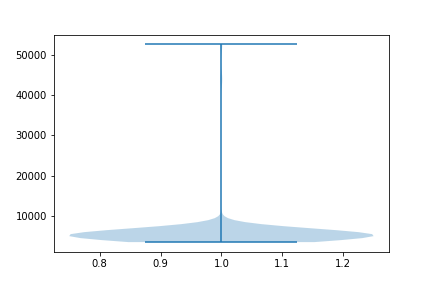

{'bodies': [<matplotlib.collections.PolyCollection at 0x2dfe9a97e88>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x2dff1885ac8>,
 'cmins': <matplotlib.collections.LineCollection at 0x2dfe9aae1c8>,
 'cbars': <matplotlib.collections.LineCollection at 0x2dfe9aa6c88>}

In [174]:
plt.figure()
plt.violinplot(gpfinals[:,0])

<IPython.core.display.Javascript object>


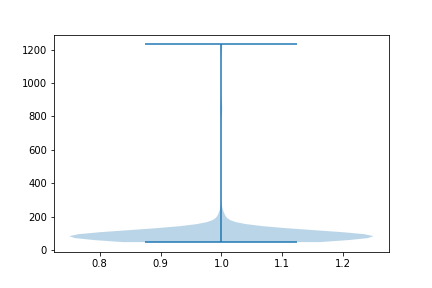

{'bodies': [<matplotlib.collections.PolyCollection at 0x2dfea858dc8>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x2dfea8513c8>,
 'cmins': <matplotlib.collections.LineCollection at 0x2dfea861e48>,
 'cbars': <matplotlib.collections.LineCollection at 0x2dfea861dc8>}

In [180]:
plt.figure()
plt.violinplot(gpfinals[:,1])

In [190]:
gpci_0 = sorted(gpfinals[:,0])
print(gpci_0[10], gpci_0[-11])

4160.458766263764 6688.040011871959


In [191]:
gpci_1 = sorted(gpfinals[:,1])
print(gpci_1[10], gpci_1[-11])

63.35261609831754 119.54592395884247


<IPython.core.display.Javascript object>


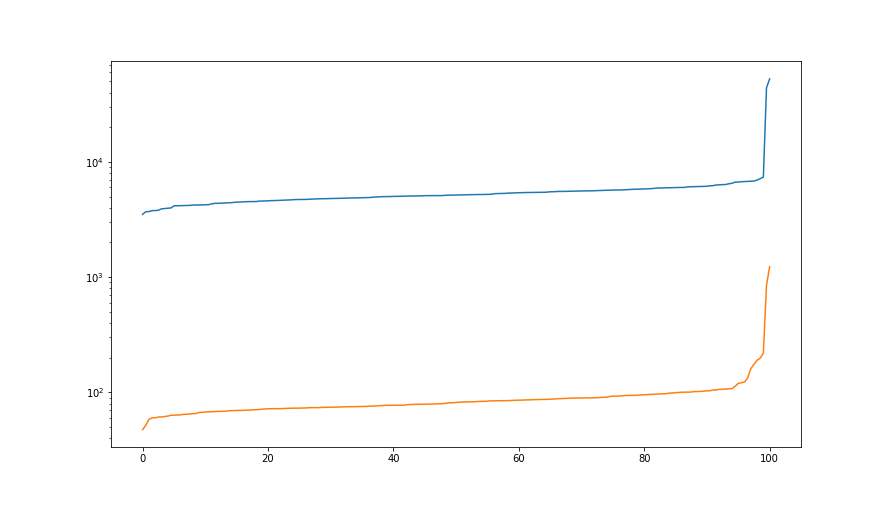

In [189]:
plt.figure()
plt.semilogy(np.linspace(0,100,len(gpci_0)), gpci_0)
plt.semilogy(np.linspace(0,100,len(gpci_1)), gpci_1)